# Bechdel Analysis
#### CS5850 Final Project

Alex Thurston, Hailey Dennis, Tyler Kunz

# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from numpy import linalg,mean,dot
from pandas import DataFrame
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# Get five-thirty-eight bechdel data
def get_five_thirty_eight_bechdel_data():
    data = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/bechdel/movies.csv")
    select_columns = data[['year', 'imdb', 'title', 'clean_test', 'binary', 'budget_2013$', 'domgross_2013$', 'intgross_2013$']]
    return select_columns

In [3]:
# Print correlation and covariance matrices
def print_corr_cov_matrices(data):
    print(data.corr())
    print(data.cov())

In [4]:
# Check for duplicates: True if duplicates were found, False if all data is unique
def check_duplicates(data):
    if len(select_columns['imdb']) != len(select_columns['imdb'].unique()):
        return True
    else:
        return False

In [5]:
# Add column to dataframe
def add_column(df, col_name, new_list):
    df.insert(len(df.columns), str(col_name), new_list)
    return df

In [6]:
# Returns percentage of women in given crew role (e.g. Producer, Director
def get_perc_women_role(crew_response, job_type):
    female_count = 0
    job_count = 0
    for person in crew_response['crew']:
        if person['job'] == job_type:
            job_count += 1
            if person['gender'] == 1:
                female_count += 1
    if job_count == 0:
        return None
    else:
        return female_count / job_count

In [7]:
# Populate data
data_file_name = "bechdel_analysis_data.csv"
data_file_path = "./bechdel_analysis_data.csv"

# See if data has already been populated in the current directory
if os.path.isfile(data_file_path) == 'test':
    select_columns = pd.read_csv(data_file_path)
else:
    select_columns = get_five_thirty_eight_bechdel_data()
    
#Gather TMDB data - setup
tmdb_api_key = "55d7071c3daf17bcf8cc0f4a6f688a24"
movie_ids = select_columns['imdb']


# Initialize empty arrays
adult = [None] * len(movie_ids)
genres = [None] * len(movie_ids)
prod_comps = [None] * len(movie_ids)
overview = [None] * len(movie_ids)
perc_women_producers = [None] * len(movie_ids)
perc_women_directors = [None] * len(movie_ids)

# Query the API for data
for i in range(len(movie_ids)):
    try:
        response = requests.get("https://api.themoviedb.org/3/movie/" + str(movie_ids[i]) + "?api_key=" + str(tmdb_api_key) + "&language=en-US").json()
        crew_response = requests.get("https://api.themoviedb.org/3/movie/" + str(movie_ids[i]) + "/credits?api_key=" + str(tmdb_api_key) + "&language=en-US").json()
        adult[i] = response['adult']
        genres[i] = ','.join([ genre['name'] for genre in response['genres']])
        prod_comps[i] = ','.join([company['name'] for company in response['production_companies']])
        overview[i] = response['overview']
        perc_women_producers[i] = get_perc_women_role(crew_response, 'Producer')
        perc_women_directors[i] = get_perc_women_role(crew_response, 'Director')

    except Exception as err:
        print(f"Unexpected {err=}, {type(err)=}")
        continue

# Add desired columns to select_columns
desired_cols = {'adult': adult, 'genres': genres, 'prod_comps': prod_comps, 'overview': overview,
                'perc_women_producers': perc_women_producers, 
                'perc_women_directors': perc_women_directors}
for key in desired_cols.keys():
    select_columns = add_column(select_columns, key, desired_cols[key])

#Save to csv so we don't have to requery the API every time
select_columns.to_csv(data_file_name, encoding='utf-8', index=False)

Unexpected err=KeyError('adult'), type(err)=<class 'KeyError'>
Unexpected err=KeyError('adult'), type(err)=<class 'KeyError'>
Unexpected err=KeyError('adult'), type(err)=<class 'KeyError'>
Unexpected err=KeyError('adult'), type(err)=<class 'KeyError'>
Unexpected err=KeyError('adult'), type(err)=<class 'KeyError'>
Unexpected err=KeyError('adult'), type(err)=<class 'KeyError'>


In [8]:
# Check for null values: return columns and sums of null values located in each
def null_values_in_columns(data):
    null_cols = data.isnull().any()
    return [data.columns[i] for i in range(len(data.columns)) if null_cols[i] == True]

cols_with_nulls = null_values_in_columns(select_columns)
print(cols_with_nulls)

['domgross_2013$', 'intgross_2013$', 'adult', 'genres', 'prod_comps', 'overview', 'perc_women_producers', 'perc_women_directors']


In [9]:
# mutative function to remove rows with nulls
def get_non_null_rows(df, col_with_nulls):
    df = df[df[col_with_nulls].isnull() == False]
    return df

In [10]:
for i in cols_with_nulls:
    select_columns = get_non_null_rows(select_columns, i)
    
select_columns.dropna()

,year,imdb,title,clean_test,binary,budget_2013$,domgross_2013$,intgross_2013$,adult,genres,prod_comps,overview,perc_women_producers,perc_women_directors
0,2013,tt1711425,21 &amp; Over,notalk,FAIL,13000000,25682380.0,42195766.0,False,Comedy,"Mandeville Films,Relativity Media,SkyLand Ente...",Brilliant student Jeff Chang has the most impo...,0.00,0.0
1,2012,tt1343727,Dredd 3D,ok,PASS,45658735,13611086.0,41467257.0,False,"Action,Science Fiction","Rena Film,DNA Films,Reliance Big Entertainment...","In the future, America is a dystopian wastelan...",0.00,0.0
2,2013,tt2024544,12 Years a Slave,notalk,FAIL,20000000,53107035.0,158607035.0,False,"Drama,History","New Regency Pictures,Plan B Entertainment,Rive...","In the pre-Civil War United States, Solomon No...",0.25,0.0
3,2013,tt1272878,2 Guns,notalk,FAIL,61000000,75612460.0,132493015.0,False,"Action,Comedy,Crime","Universal Pictures,Marc Platt Productions,EFO ...",A DEA agent and an undercover Naval Intelligen...,0.00,0.0
4,2013,tt0453562,42,men,FAIL,40000000,95020213.0,95020213.0,False,Drama,"Warner Bros. Pictures,Legendary Pictures","The powerful story of Jackie Robinson, the leg...",0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1789,1971,tt0067741,Shaft,notalk,FAIL,305063707,404702718.0,616827003.0,False,"Action,Crime,Thriller","Shaft Productions,Metro-Goldwyn-Mayer",Cool black private eye John Shaft is hired by ...,0.00,0.0
1790,1971,tt0067800,Straw Dogs,notalk,FAIL,143862856,59412143.0,64760273.0,False,"Crime,Drama,Thriller",ABC Pictures,"David Sumner, a mild-mannered academic from th...",0.00,0.0
1791,1971,tt0067116,The French Connection,notalk,FAIL,12659931,236848653.0,236848653.0,False,"Action,Crime,Thriller","D'Antoni Productions,Schine-Moore Productions,...",Tough narcotics detective 'Popeye' Doyle is in...,0.00,0.0
1792,1971,tt0067992,Willy Wonka &amp; the Chocolate Factory,men,FAIL,17263543,23018057.0,23018057.0,False,"Family,Fantasy,Comedy",David L. Wolper Productions,When eccentric candy man Willy Wonka promises ...,0.00,0.0


In [11]:
print(null_values_in_columns(select_columns))
print()
print(select_columns.isnull().sum())
print()
print(select_columns)

[]

year                    0
imdb                    0
title                   0
clean_test              0
binary                  0
budget_2013$            0
domgross_2013$          0
intgross_2013$          0
adult                   0
genres                  0
prod_comps              0
overview                0
perc_women_producers    0
perc_women_directors    0
dtype: int64

      year       imdb                                    title clean_test  \
0     2013  tt1711425                            21 &amp; Over     notalk   
1     2012  tt1343727                                 Dredd 3D         ok   
2     2013  tt2024544                         12 Years a Slave     notalk   
3     2013  tt1272878                                   2 Guns     notalk   
4     2013  tt0453562                                       42        men   
...    ...        ...                                      ...        ...   
1789  1971  tt0067741                                    Shaft     notalk   
17

In [12]:
select_columns.to_csv("bechdel_analysis_data_cleaned.csv", encoding='utf-8', index=False)

# Feature Selection
Determining which features have a strong correlation with movies' Bechdel Test result.

In [13]:
def currency_conversion(amt):
    return "${:,.2f}".format(amt)

# Modes = 'overall', 'passing', 'failing' -- make sure you pass in data that corresponds to the mode!
def quick_metrics(column_name, xdata, mode, currency=False):
    if currency:
        print(f"{column_name} min {mode}:", currency_conversion(xdata.min()))
        print(f"{column_name} max {mode}:", currency_conversion(xdata.max()))
        print(f"{column_name} mean {mode}:", currency_conversion(xdata.mean()))
        print(f"{column_name} standard deviation {mode}:", currency_conversion(xdata.std()))
    else:
        print(f"{column_name} min {mode}:", xdata.min())
        print(f"{column_name} max {mode}:", xdata.max())
        print(f"{column_name} mean {mode}:", xdata.mean())
        print(f"{column_name} standard deviation {mode}:", xdata.std())

In [14]:
data = pd.read_csv("bechdel_analysis_data_cleaned.csv", float_precision=None)
data = data.dropna()
data

,year,imdb,title,clean_test,binary,budget_2013$,domgross_2013$,intgross_2013$,adult,genres,prod_comps,overview,perc_women_producers,perc_women_directors
0,2013,tt1711425,21 &amp; Over,notalk,FAIL,13000000,25682380.0,42195766.0,False,Comedy,"Mandeville Films,Relativity Media,SkyLand Ente...",Brilliant student Jeff Chang has the most impo...,0.00,0.0
1,2012,tt1343727,Dredd 3D,ok,PASS,45658735,13611086.0,41467257.0,False,"Action,Science Fiction","Rena Film,DNA Films,Reliance Big Entertainment...","In the future, America is a dystopian wastelan...",0.00,0.0
2,2013,tt2024544,12 Years a Slave,notalk,FAIL,20000000,53107035.0,158607035.0,False,"Drama,History","New Regency Pictures,Plan B Entertainment,Rive...","In the pre-Civil War United States, Solomon No...",0.25,0.0
3,2013,tt1272878,2 Guns,notalk,FAIL,61000000,75612460.0,132493015.0,False,"Action,Comedy,Crime","Universal Pictures,Marc Platt Productions,EFO ...",A DEA agent and an undercover Naval Intelligen...,0.00,0.0
4,2013,tt0453562,42,men,FAIL,40000000,95020213.0,95020213.0,False,Drama,"Warner Bros. Pictures,Legendary Pictures","The powerful story of Jackie Robinson, the leg...",0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,1971,tt0067741,Shaft,notalk,FAIL,305063707,404702718.0,616827003.0,False,"Action,Crime,Thriller","Shaft Productions,Metro-Goldwyn-Mayer",Cool black private eye John Shaft is hired by ...,0.00,0.0
1735,1971,tt0067800,Straw Dogs,notalk,FAIL,143862856,59412143.0,64760273.0,False,"Crime,Drama,Thriller",ABC Pictures,"David Sumner, a mild-mannered academic from th...",0.00,0.0
1736,1971,tt0067116,The French Connection,notalk,FAIL,12659931,236848653.0,236848653.0,False,"Action,Crime,Thriller","D'Antoni Productions,Schine-Moore Productions,...",Tough narcotics detective 'Popeye' Doyle is in...,0.00,0.0
1737,1971,tt0067992,Willy Wonka &amp; the Chocolate Factory,men,FAIL,17263543,23018057.0,23018057.0,False,"Family,Fantasy,Comedy",David L. Wolper Productions,When eccentric candy man Willy Wonka promises ...,0.00,0.0


In [15]:
data.corr()

,year,budget_2013$,domgross_2013$,intgross_2013$,adult,perc_women_producers,perc_women_directors
year,1.000000,0.084729,-0.285485,-0.132599,NaN,0.078965,0.046855
budget_2013$,0.084729,1.000000,0.455839,0.589860,NaN,0.034831,-0.119151
domgross_2013$,-0.285485,0.455839,1.000000,0.927203,NaN,-0.010985,-0.105564
intgross_2013$,-0.132599,0.589860,0.927203,1.000000,NaN,0.009160,-0.094765
adult,NaN,NaN,NaN,NaN,NaN,NaN,NaN
perc_women_producers,0.078965,0.034831,-0.010985,0.009160,NaN,1.000000,0.175726
perc_women_directors,0.046855,-0.119151,-0.105564,-0.094765,NaN,0.175726,1.000000


In [16]:
data.cov()

,year,budget_2013$,domgross_2013$,intgross_2013$,adult,perc_women_producers,perc_women_directors
year,8.130898e+01,4.215355e+07,-3.267549e+08,-3.420201e+08,0.0,0.193782,1.065891e-01
budget_2013$,4.215355e+07,3.044149e+15,3.192382e+15,9.309453e+15,0.0,523012.635563,-1.658505e+06
domgross_2013$,-3.267549e+08,3.192382e+15,1.611165e+16,3.366567e+16,0.0,-379479.927320,-3.380402e+06
intgross_2013$,-3.420201e+08,9.309453e+15,3.366567e+16,8.182480e+16,0.0,713085.720026,-6.838746e+06
adult,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00
perc_women_producers,1.937816e-01,5.230126e+05,-3.794799e+05,7.130857e+05,0.0,0.074066,1.206513e-02
perc_women_directors,1.065891e-01,-1.658505e+06,-3.380402e+06,-6.838746e+06,0.0,0.012065,6.364568e-02


Convert the pass/fail string binary column to 1=pass and 0=fail.

In [17]:
pass_fail_data = pd.get_dummies(data.binary, prefix='binary')
pass_fail_data = pass_fail_data.drop("binary_FAIL", axis=1)
data = data.drop(columns=['binary'])
data.insert(5, "binary_PASS", pass_fail_data["binary_PASS"])
data_new = data
data_new

,year,imdb,title,clean_test,budget_2013$,binary_PASS,domgross_2013$,intgross_2013$,adult,genres,prod_comps,overview,perc_women_producers,perc_women_directors
0,2013,tt1711425,21 &amp; Over,notalk,13000000,0,25682380.0,42195766.0,False,Comedy,"Mandeville Films,Relativity Media,SkyLand Ente...",Brilliant student Jeff Chang has the most impo...,0.00,0.0
1,2012,tt1343727,Dredd 3D,ok,45658735,1,13611086.0,41467257.0,False,"Action,Science Fiction","Rena Film,DNA Films,Reliance Big Entertainment...","In the future, America is a dystopian wastelan...",0.00,0.0
2,2013,tt2024544,12 Years a Slave,notalk,20000000,0,53107035.0,158607035.0,False,"Drama,History","New Regency Pictures,Plan B Entertainment,Rive...","In the pre-Civil War United States, Solomon No...",0.25,0.0
3,2013,tt1272878,2 Guns,notalk,61000000,0,75612460.0,132493015.0,False,"Action,Comedy,Crime","Universal Pictures,Marc Platt Productions,EFO ...",A DEA agent and an undercover Naval Intelligen...,0.00,0.0
4,2013,tt0453562,42,men,40000000,0,95020213.0,95020213.0,False,Drama,"Warner Bros. Pictures,Legendary Pictures","The powerful story of Jackie Robinson, the leg...",0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,1971,tt0067741,Shaft,notalk,305063707,0,404702718.0,616827003.0,False,"Action,Crime,Thriller","Shaft Productions,Metro-Goldwyn-Mayer",Cool black private eye John Shaft is hired by ...,0.00,0.0
1735,1971,tt0067800,Straw Dogs,notalk,143862856,0,59412143.0,64760273.0,False,"Crime,Drama,Thriller",ABC Pictures,"David Sumner, a mild-mannered academic from th...",0.00,0.0
1736,1971,tt0067116,The French Connection,notalk,12659931,0,236848653.0,236848653.0,False,"Action,Crime,Thriller","D'Antoni Productions,Schine-Moore Productions,...",Tough narcotics detective 'Popeye' Doyle is in...,0.00,0.0
1737,1971,tt0067992,Willy Wonka &amp; the Chocolate Factory,men,17263543,0,23018057.0,23018057.0,False,"Family,Fantasy,Comedy",David L. Wolper Productions,When eccentric candy man Willy Wonka promises ...,0.00,0.0


In [18]:
data_new.corr()

,year,budget_2013$,binary_PASS,domgross_2013$,intgross_2013$,adult,perc_women_producers,perc_women_directors
year,1.000000,0.084729,0.085234,-0.285485,-0.132599,NaN,0.078965,0.046855
budget_2013$,0.084729,1.000000,-0.147776,0.455839,0.589860,NaN,0.034831,-0.119151
binary_PASS,0.085234,-0.147776,1.000000,-0.108315,-0.093304,NaN,0.089688,0.201867
domgross_2013$,-0.285485,0.455839,-0.108315,1.000000,0.927203,NaN,-0.010985,-0.105564
intgross_2013$,-0.132599,0.589860,-0.093304,0.927203,1.000000,NaN,0.009160,-0.094765
adult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
perc_women_producers,0.078965,0.034831,0.089688,-0.010985,0.009160,NaN,1.000000,0.175726
perc_women_directors,0.046855,-0.119151,0.201867,-0.105564,-0.094765,NaN,0.175726,1.000000


In [19]:
data_new.mad()

year                    6.988840e+00
budget_2013$            4.185189e+07
binary_PASS             4.935821e-01
domgross_2013$          8.102080e+07
intgross_2013$          1.844418e+08
adult                   0.000000e+00
perc_women_producers    2.144761e-01
perc_women_directors    1.310545e-01
dtype: float64

Observations:
- Low positive correlation between year and passing
- Low negative correlation between all monetary categories and passing
- Fairly high correlations between all monetary categories with each other
- Percentage of women directors had the largest correlation (positive) with passing at .2
- High correlation between domgross_2013 and int_gross2013
 - We will opt to remove int_gross2013 as it has a significantly lower mean absolute deviation
 - We will keep budget_2013 as it stil offers significant variability
- Adult needs to be removed

### Domestic Gross Analysis

In [20]:
data_fail = data_new.loc[data_new["binary_PASS"] == 0] 
data_pass = data_new.loc[data_new["binary_PASS"] == 1] 

In [21]:
quick_metrics('domgross_2013$', data_new['domgross_2013$'], 'overall', True)

domgross_2013$ min overall: $899.00
domgross_2013$ max overall: $1,771,682,790.00
domgross_2013$ mean overall: $96,834,868.19
domgross_2013$ standard deviation overall: $126,931,675.87


In [22]:
quick_metrics('domgross_2013$', data_pass['domgross_2013$'], 'passing', True)

domgross_2013$ min passing: $9,824.00
domgross_2013$ max passing: $1,074,306,128.00
domgross_2013$ mean passing: $81,433,835.68
domgross_2013$ standard deviation passing: $103,823,837.95


In [23]:
quick_metrics('domgross_2013$', data_fail['domgross_2013$'], 'failing', True)

domgross_2013$ min failing: $899.00
domgross_2013$ max failing: $1,771,682,790.00
domgross_2013$ mean failing: $109,101,318.80
domgross_2013$ standard deviation failing: $141,543,343.95


Text(0, 0.5, 'Domestic Gross Sales ($100 million)')

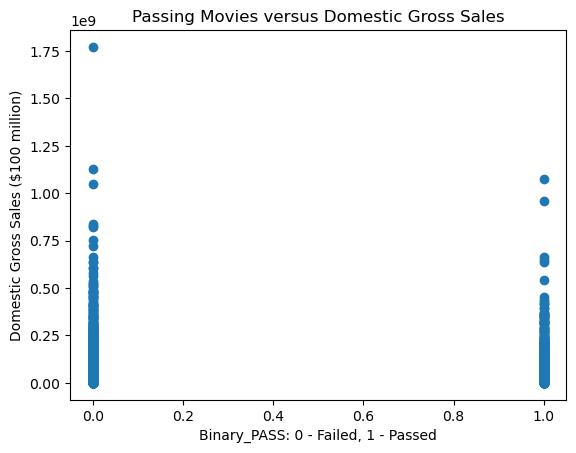

In [24]:
plt.scatter(data_new["binary_PASS"], data_new["domgross_2013$"])
plt.title("Passing Movies versus Domestic Gross Sales")
plt.xlabel("Binary_PASS: 0 - Failed, 1 - Passed")
plt.ylabel("Domestic Gross Sales ($100 million)")

Text(0, 0.5, '2013 Average Domestic Gross ($100 million)')

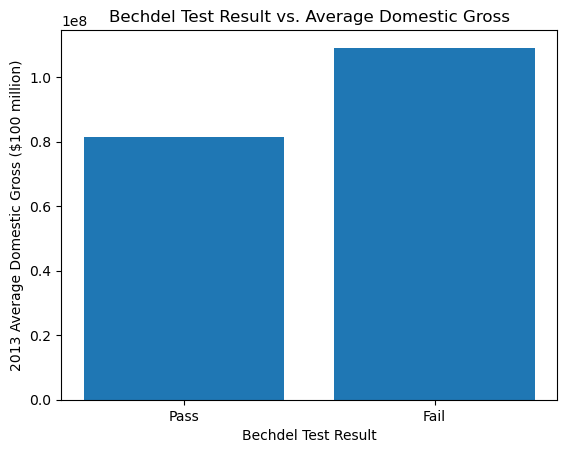

In [25]:
plt.bar(["Pass", "Fail"], [data_pass["domgross_2013$"].mean(), data_fail["domgross_2013$"].mean()])
plt.title("Bechdel Test Result vs. Average Domestic Gross")
plt.xlabel("Bechdel Test Result")
plt.ylabel("2013 Average Domestic Gross ($100 million)")

Observations:

- There is a clear correlation between 2013 average domestic gross and Bechdel Test result
- Lower domestic gross sales means higher likelihood to pass the Bechdel test


### Budget Analysis

In [26]:
quick_metrics('budget_2013$', data_new['budget_2013$'], 'overall', True)

budget_2013$ min overall: $8,632.00
budget_2013$ max overall: $461,435,929.00
budget_2013$ mean overall: $56,646,503.17
budget_2013$ standard deviation overall: $55,173,808.69


In [27]:
quick_metrics('budget_2013$', data_pass['budget_2013$'], 'passing', True)

budget_2013$ min passing: $39,349.00
budget_2013$ max passing: $337,063,045.00
budget_2013$ mean passing: $47,513,235.72
budget_2013$ standard deviation passing: $49,102,845.43


In [28]:
quick_metrics('budget_2013$', data_fail['budget_2013$'], 'failing', True)

budget_2013$ min failing: $8,632.00
budget_2013$ max failing: $461,435,929.00
budget_2013$ mean failing: $63,920,870.91
budget_2013$ standard deviation failing: $58,582,532.12


Text(0, 0.5, 'Budget ($100 million)')

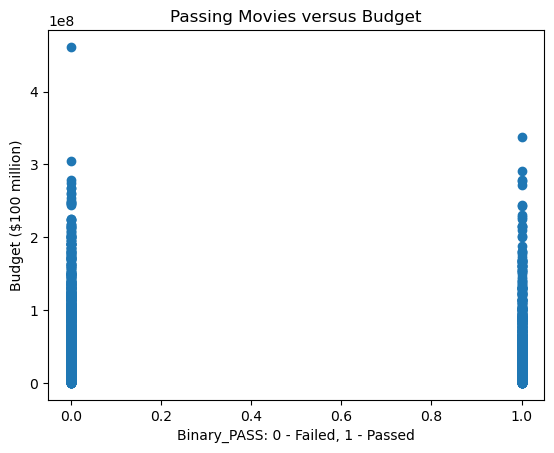

In [29]:
plt.scatter(data_new["binary_PASS"], data_new["budget_2013$"])
plt.title("Passing Movies versus Budget")
plt.xlabel("Binary_PASS: 0 - Failed, 1 - Passed")
plt.ylabel("Budget ($100 million)")

Text(0, 0.5, 'Average Budget ($100 million)')

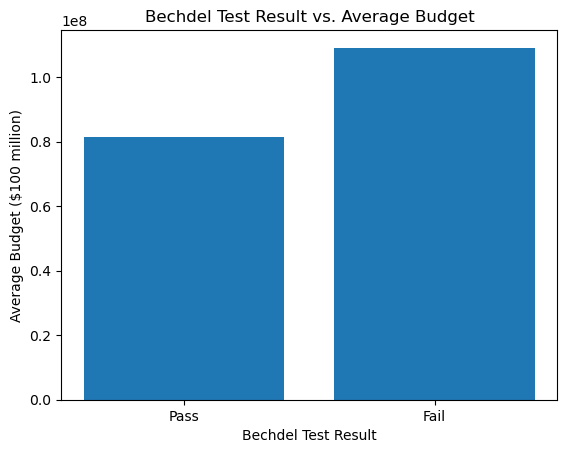

In [30]:
plt.bar(["Pass", "Fail"], [data_pass["domgross_2013$"].mean(), data_fail["domgross_2013$"].mean()])
plt.title("Bechdel Test Result vs. Average Budget")
plt.xlabel("Bechdel Test Result")
plt.ylabel("Average Budget ($100 million)")

Observations:

- Similar observations to the domestic gross sales
- Movies that fail the Bechdel test have a higher average budget

### Genre Analysis

In [31]:
data_new["genres"] = data_new["genres"].str.split(',')

In [32]:
mlb = MultiLabelBinarizer()
genre_data = pd.DataFrame(mlb.fit_transform(data_new["genres"]),
                          columns=mlb.classes_,
                          index=data_new.index)
genre_data

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1735,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
1736,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1737,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0


In [42]:
main_data_genre_data_combined = pd.concat([data_new.reset_index(drop=True),genre_data.reset_index(drop=True)], axis=1)
main_data_genre_data_combined.to_csv("bechdel_analysis_data_cleaned_with_genres.csv")
main_data_genre_data_combined

,year,imdb,title,clean_test,budget_2013$,binary_PASS,domgross_2013$,intgross_2013$,adult,genres,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,2013,tt1711425,21 &amp; Over,notalk,13000000,0,25682380.0,42195766.0,False,[Comedy],...,0,0,0,0,0,0,0,0,0,0
1,2012,tt1343727,Dredd 3D,ok,45658735,1,13611086.0,41467257.0,False,"[Action, Science Fiction]",...,0,0,0,0,0,0,1,0,0,0
2,2013,tt2024544,12 Years a Slave,notalk,20000000,0,53107035.0,158607035.0,False,"[Drama, History]",...,0,1,0,0,0,0,0,0,0,0
3,2013,tt1272878,2 Guns,notalk,61000000,0,75612460.0,132493015.0,False,"[Action, Comedy, Crime]",...,0,0,0,0,0,0,0,0,0,0
4,2013,tt0453562,42,men,40000000,0,95020213.0,95020213.0,False,[Drama],...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725,1971,tt0067741,Shaft,notalk,305063707,0,404702718.0,616827003.0,False,"[Action, Crime, Thriller]",...,0,0,0,0,0,0,0,1,0,0
1726,1971,tt0067800,Straw Dogs,notalk,143862856,0,59412143.0,64760273.0,False,"[Crime, Drama, Thriller]",...,0,0,0,0,0,0,0,1,0,0
1727,1971,tt0067116,The French Connection,notalk,12659931,0,236848653.0,236848653.0,False,"[Action, Crime, Thriller]",...,0,0,0,0,0,0,0,1,0,0
1728,1971,tt0067992,Willy Wonka &amp; the Chocolate Factory,men,17263543,0,23018057.0,23018057.0,False,"[Family, Fantasy, Comedy]",...,1,0,0,0,0,0,0,0,0,0


In [43]:
genre_data.to_csv("genre_data.csv")

In [44]:
print("Genre by Movie Count")
genre_data.sum().sort_values(ascending=False)

Genre by Movie Count


Drama              763
Comedy             637
Action             488
Thriller           461
Adventure          388
Romance            321
Science Fiction    290
Crime              264
Fantasy            233
Family             199
Horror             193
Mystery            151
Animation          116
History             70
War                 51
Music               50
Western             25
Documentary          4
dtype: int64

In [45]:
pass_fail_genre = pd.concat([pass_fail_data, genre_data], axis=1)

In [46]:
print("Correlation between genre and test results")
pass_fail_genre_corr = pass_fail_genre.corr()
pass_fail_genre_corr[["binary_PASS"]]

Correlation between genre and test results


,binary_PASS
binary_PASS,1.000000
Action,-0.210356
Adventure,-0.133959
Animation,-0.048517
Comedy,0.061721
Crime,-0.106924
Documentary,-0.018737
Drama,0.069653
Family,0.021053
Fantasy,-0.004435


In [47]:
print("Covariance between genre and test results")
pass_fail_genre_cov = pass_fail_genre.cov()
pass_fail_genre_cov[["binary_PASS"]]

Covariance between genre and test results


,binary_PASS
binary_PASS,0.246934
Action,-0.047054
Adventure,-0.027774
Animation,-0.006032
Comedy,0.014797
Crime,-0.019112
Documentary,-0.000447
Drama,0.017190
Family,0.003339
Fantasy,-0.000753


- Genres with a clear positive correlation above 0.1 include romance and horror
- Genres with a clear negative correlation above 0.1 include action, adventure, and crime

### Year Analysis

Text(0.5, 0, 'Year')

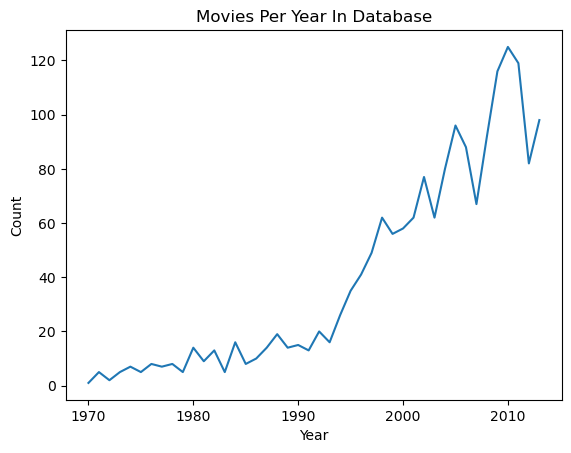

In [48]:
year_data = data_new[['binary_PASS','year']].groupby('year').count()
plt.plot(year_data.index,year_data['binary_PASS'])
plt.title("Movies Per Year In Database")
plt.ylabel("Count")
plt.xlabel("Year")

In [49]:
print("\nPass rate by year")
year_pass_data = data_new[data_new["binary_PASS"] == 1]
year_pass_data = year_pass_data[['binary_PASS','year']].groupby('year').count()
pass_percentage_data = year_pass_data / year_data
pass_percentage_data = pass_percentage_data.fillna(0)
pass_percentage_data


Pass rate by year


,binary_PASS
year,
1970,1.000000
1971,0.000000
1972,0.500000
1973,0.200000
1974,0.285714
1975,0.000000
1976,0.375000
1977,0.285714
1978,0.250000


Text(0.5, 0, 'Year')

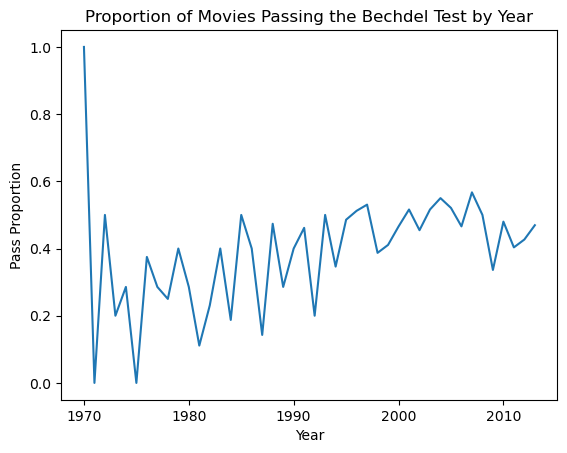

In [50]:
plt.plot(pass_percentage_data.index,pass_percentage_data['binary_PASS'])
plt.title("Proportion of Movies Passing the Bechdel Test by Year")
plt.ylabel("Pass Proportion")
plt.xlabel("Year")

In [51]:
pass_percentage_post94 = pass_percentage_data[pass_percentage_data.index >= 1994].mean()
pass_percentage_pre94 = pass_percentage_data[pass_percentage_data.index < 1994].mean()


print("Average pass rate for movies prior to 1994:\n", pass_percentage_pre94)
print("Average pass rate for movies 1994 and later:\n", pass_percentage_post94)

Average pass rate for movies prior to 1994:
 binary_PASS    0.328138
dtype: float64
Average pass rate for movies 1994 and later:
 binary_PASS    0.467225
dtype: float64


- Pass rate fluctuated greatly by year in early years, likely because of the smaller sample size
- Rates seem to be stabilizing around .5 over time
- Average pass rate slowly increases over time
- Number of movies per year spiked following 1994-ish
- Majority of our data averages near a 50% pass rate, but is lower prior to 1994 (less values)

### Adult Movie Analysis

In [52]:
adult_data = pd.get_dummies(data.adult, prefix='adult')
adult_data

,adult_False
0,1
1,1
2,1
3,1
4,1
...,...
1734,1
1735,1
1736,1
1737,1


No adult movies in the dataset.

### Production Company Analysis

Should revisit this later

In [53]:
data_new["prod_comps"] = data_new["prod_comps"].str.split(',')
data_new

,year,imdb,title,clean_test,budget_2013$,binary_PASS,domgross_2013$,intgross_2013$,adult,genres,prod_comps,overview,perc_women_producers,perc_women_directors
0,2013,tt1711425,21 &amp; Over,notalk,13000000,0,25682380.0,42195766.0,False,[Comedy],"[Mandeville Films, Relativity Media, SkyLand E...",Brilliant student Jeff Chang has the most impo...,0.00,0.0
1,2012,tt1343727,Dredd 3D,ok,45658735,1,13611086.0,41467257.0,False,"[Action, Science Fiction]","[Rena Film, DNA Films, Reliance Big Entertainm...","In the future, America is a dystopian wastelan...",0.00,0.0
2,2013,tt2024544,12 Years a Slave,notalk,20000000,0,53107035.0,158607035.0,False,"[Drama, History]","[New Regency Pictures, Plan B Entertainment, R...","In the pre-Civil War United States, Solomon No...",0.25,0.0
3,2013,tt1272878,2 Guns,notalk,61000000,0,75612460.0,132493015.0,False,"[Action, Comedy, Crime]","[Universal Pictures, Marc Platt Productions, E...",A DEA agent and an undercover Naval Intelligen...,0.00,0.0
4,2013,tt0453562,42,men,40000000,0,95020213.0,95020213.0,False,[Drama],"[Warner Bros. Pictures, Legendary Pictures]","The powerful story of Jackie Robinson, the leg...",0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,1971,tt0067741,Shaft,notalk,305063707,0,404702718.0,616827003.0,False,"[Action, Crime, Thriller]","[Shaft Productions, Metro-Goldwyn-Mayer]",Cool black private eye John Shaft is hired by ...,0.00,0.0
1735,1971,tt0067800,Straw Dogs,notalk,143862856,0,59412143.0,64760273.0,False,"[Crime, Drama, Thriller]",[ABC Pictures],"David Sumner, a mild-mannered academic from th...",0.00,0.0
1736,1971,tt0067116,The French Connection,notalk,12659931,0,236848653.0,236848653.0,False,"[Action, Crime, Thriller]","[D'Antoni Productions, Schine-Moore Production...",Tough narcotics detective 'Popeye' Doyle is in...,0.00,0.0
1737,1971,tt0067992,Willy Wonka &amp; the Chocolate Factory,men,17263543,0,23018057.0,23018057.0,False,"[Family, Fantasy, Comedy]",[David L. Wolper Productions],When eccentric candy man Willy Wonka promises ...,0.00,0.0


### Overview Analysis

Leaving this here so we can revisit it

### Percentage of Women Producers Analysis

In [54]:
# Percentage of movies with no women producers
no_women = data_new.loc[data_new['perc_women_producers'] == 0]
no_women.shape[0] / data_new.shape[0]

0.6630057803468208

In [55]:
quick_metrics("perc_women_producers", data_new['perc_women_producers'], 'overall', False)

perc_women_producers min overall: 0.0
perc_women_producers max overall: 1.0
perc_women_producers mean overall: 0.1614746974284546
perc_women_producers standard deviation overall: 0.27215147606150425


Text(0, 0.5, 'Percentage Passing')

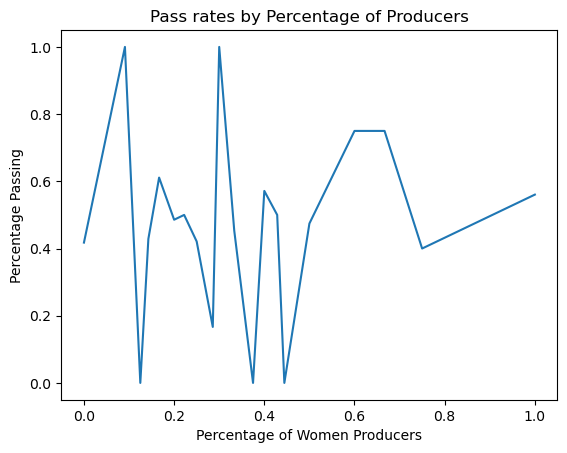

In [56]:
p_percs = data_new['perc_women_producers'].unique()
p_percs.sort()

pass_p_percs = []

for p in p_percs:
    rows = data_new.loc[data_new['perc_women_producers'] == p]
    passed = rows.loc[data_new['binary_PASS'] == 1]
    pass_p_percs.append(passed.shape[0] / rows.shape[0])
    
plt.plot(p_percs, pass_p_percs)
plt.title("Pass rates by Percentage of Producers")
plt.xlabel("Percentage of Women Producers")
plt.ylabel("Percentage Passing")

### Percentage of Women Directors Analysis

In [57]:
# Percentage of movies with no women directors
no_women = data_new.loc[data_new['perc_women_directors'] == 0]
no_women.shape[0] / data_new.shape[0]

0.923699421965318

In [58]:
quick_metrics("perc_women_directors", data_new['perc_women_directors'], 'overall', False)

perc_women_directors min overall: 0.0
perc_women_directors max overall: 1.0
perc_women_directors mean overall: 0.07093999449490779
perc_women_directors standard deviation overall: 0.252280953155684


Text(0, 0.5, 'Percentage Passing')

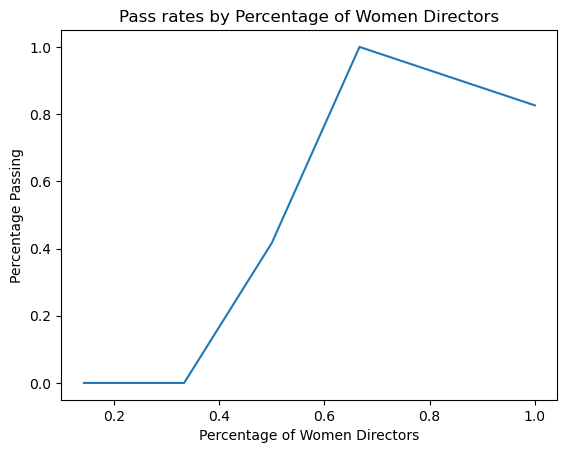

In [59]:
d_percs = data_new['perc_women_directors'].unique()
d_percs = d_percs[1:]
d_percs.sort()

pass_d_percs = []

for p in d_percs:
    rows = data_new.loc[data_new['perc_women_directors'] == p]
    passed = rows.loc[data_new['binary_PASS'] == 1]
    pass_d_percs.append(passed.shape[0] / rows.shape[0])
    
plt.plot(d_percs, pass_d_percs)
plt.title("Pass rates by Percentage of Women Directors")
plt.xlabel("Percentage of Women Directors")
plt.ylabel("Percentage Passing")

### Observations on Crew Gender

- Having women in director roles is much more indicative of a passed test than in producer roles
- It is important to note that most of the movies have no women in these roles, so the majority of the data sits at 0%
- The mean percentage of women in production roles overall is 16.15%
- The mean percentage of women in director roles overall is 7.1%

### Test Passing Binary Analysis

Text(0, 0.5, 'Movie Count')

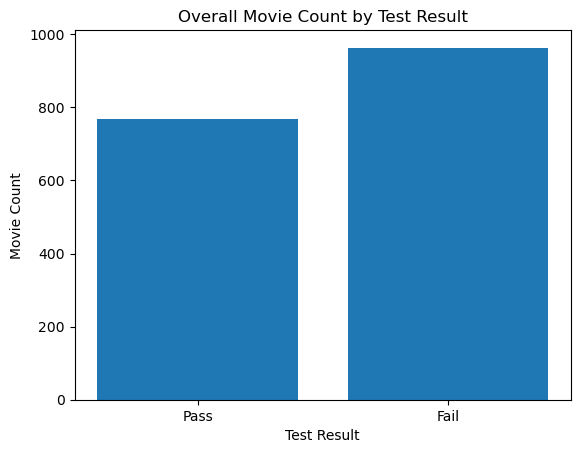

In [60]:
plt.bar(["Pass", "Fail"], [data_pass.shape[0], data_fail.shape[0]])
plt.title("Overall Movie Count by Test Result")
plt.xlabel("Test Result")
plt.ylabel("Movie Count")

We have more failing movies than passing in our dataset overall.

### Principal Component Analysis

In [61]:
pca_data = data_new[["year", "binary_PASS","budget_2013$","domgross_2013$"]]
pca_data

,year,binary_PASS,budget_2013$,domgross_2013$
0,2013,0,13000000,25682380.0
1,2012,1,45658735,13611086.0
2,2013,0,20000000,53107035.0
3,2013,0,61000000,75612460.0
4,2013,0,40000000,95020213.0
...,...,...,...,...
1734,1971,0,305063707,404702718.0
1735,1971,0,143862856,59412143.0
1736,1971,0,12659931,236848653.0
1737,1971,0,17263543,23018057.0


In [62]:
numComponents = 2
cov = pca_data.cov().to_numpy()
A = pca_data.to_numpy()
[eigvals, pcs] = linalg.eig(cov)

sorted_index = np.argsort(eigvals)[::-1]
eigvals = eigvals[sorted_index]
pcs = pcs[:,sorted_index]

print(eigvals)
M = (A-mean(A.T,axis=1)).T
projected = dot(pcs.T,M).T
projected = DataFrame(projected[:,:numComponents],columns=['pc1','pc2'])
projected

[1.68498457e+16 2.30595385e+15 6.99531705e+01 3.27936484e-01]


,pc1,pc2
0,-7.915645e+07,2.649434e+07
1,-8.355966e+07,-8.044346e+06
2,-5.085980e+07,2.585285e+07
3,-1.969600e+07,-9.022808e+06
4,-5.518323e+06,1.580972e+07
...,...,...
1725,3.559193e+08,-1.726706e+08
1726,-1.681151e+07,-9.340517e+07
1727,1.265044e+08,7.439969e+07
1728,-8.079174e+07,2.174016e+07


C:\Users\tyguy\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='pc1', ylabel='pc2'>

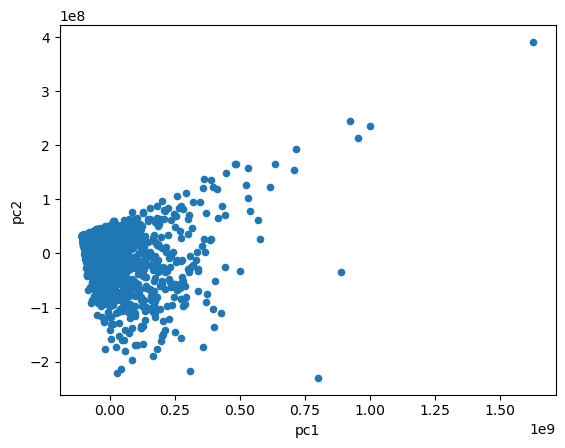

In [63]:
projected.plot(kind='scatter',x='pc1',y='pc2')

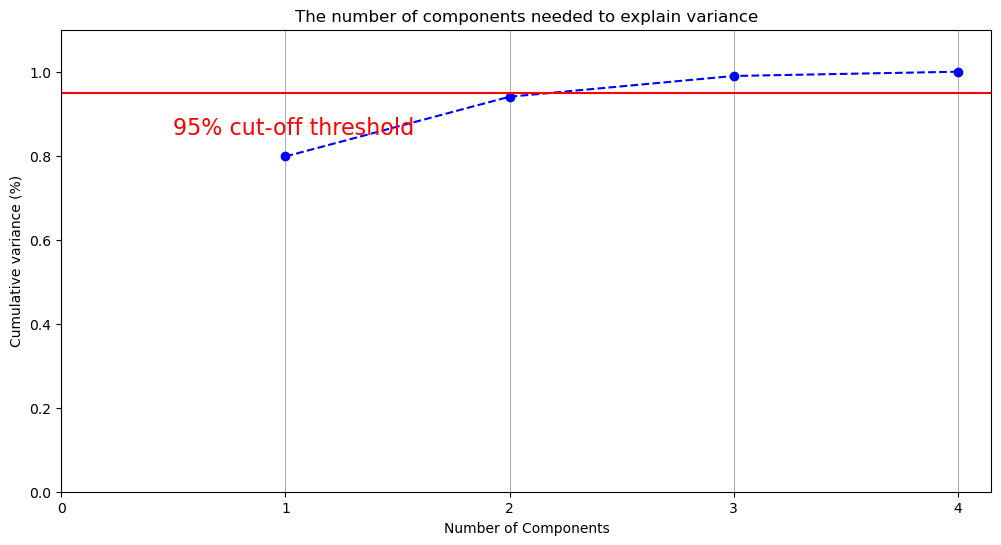

In [64]:
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(pca_data.to_numpy())
data_rescaled.shape


pca = PCA().fit(data_rescaled)


plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 5, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 5, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [65]:
pcs[:,:numComponents]

array([[-1.83299949e-08, -4.97343077e-08],
       [-4.49214434e-10,  1.04435633e-09],
       [ 2.25291769e-01, -9.74291342e-01],
       [ 9.74291342e-01,  2.25291769e-01]])

Text(0.5, 1.0, '2nd PC')

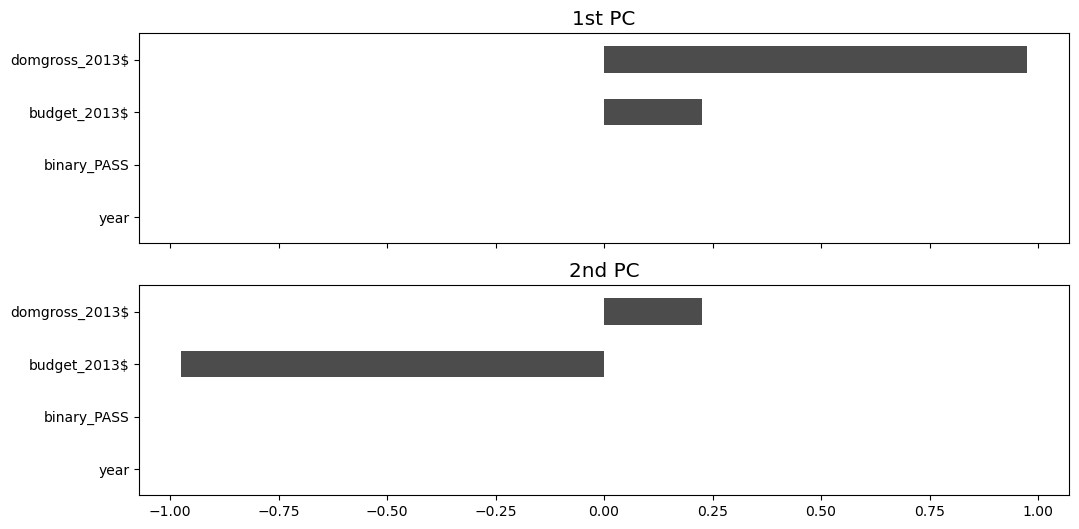

In [66]:
from pandas import Series

fig,axes = plt.subplots(2,1,sharex=True)
attrib = list(pca_data)         # get attribute names
pcdata  = Series(pcs[:,0], index=attrib)
pcdata.plot(kind='barh',ax=axes[0],color='k',alpha=0.7)
axes[0].set_title(r'1st PC', size = 'x-large')
pcdata  = Series(pcs[:,1], index=attrib)
pcdata.plot(kind='barh',ax=axes[1],color='k',alpha=0.7)
axes[1].set_title(r'2nd PC', size = 'x-large')

Observations:
- Our PCA results show a best combination of the domestic gross sales and budget.
- We feel that we gain better comprehension by separating these, and will opt not to use them.

### Summary

- We will remove the adult column as all values are false.
- We will change the representation of our classification column (binary test pass/fail to 0 or 1)
- We will remove intgross_2013 as it correlates highly with domgross_2013 but has a lower mean absolute deviation.
- The rest of our dataset has highly variable features.

In [67]:
data = data.drop(['adult'], axis=1)
data = data.drop(['intgross_2013$'], axis=1)
data.to_csv("bechdel_analysis_data_cleaned.csv", encoding='utf-8', index=False)

# Database

In the context of this project, we are using MySQL to perform queries for further data summarization and visualization. Our dataset is small enough that we feel comfortable keeping it in CSV form for other analytics.

In [68]:
import mysql.connector
from mysql.connector import errorcode
import sqlalchemy
import pandas as pd
import matplotlib.pyplot as plt

### Database Setup
This portion populates a MySQL server with values from a pandas DataFrame.

In [70]:
# Run this the first time
# !pip install pymysql

     ---------------------------------------- 43.7/43.7 kB 2.1 MB/s eta 0:00:00


In [123]:
# Configure to your own user and password
mysql_user = 'root'
mysql_pw = 'B&s3b&11nats'
mysql_host = 'localhost'

engine = sqlalchemy.create_engine(f"mysql+pymysql://{mysql_user}:{mysql_pw}@{mysql_host}")
conn = engine.connect()
conn

In [124]:
data = pd.read_csv("bechdel_analysis_data_cleaned.csv", float_precision=None)

In [125]:
def execute_dml(dml_string):
    try:
        conn.execute(dml_string)
    except mysql.connector.Error as err:
        print("Error:", err)
        
def execute_query(query_string):
    try:
        res = conn.execute(query_string)
        return res.fetchall()
    except mysql.connector.Error as err:
        print("Error:", err)

def create_db():
    drop_existing_db = "DROP DATABASE IF EXISTS bechdel;"
    create_bechdel = "CREATE DATABASE bechdel;"
    use_bechdel = "USE bechdel;"
    try:
        execute_dml(drop_existing_db)
        execute_dml(create_bechdel)
        execute_dml(use_bechdel)
    except mysql.connector.Error as err:
        print("Error:", err)
        
def populate_db():
    general_data = data.drop(['genres', 'prod_comps'], axis=1)
    general_data.to_sql('general', conn, if_exists='replace', dtype={
        'year': sqlalchemy.types.INTEGER(),
        'imdb': sqlalchemy.types.VARCHAR(length=12),
        'title': sqlalchemy.types.VARCHAR(length=255),
        'clean_test': sqlalchemy.types.VARCHAR(length=20),
        'binary_passed': sqlalchemy.types.INTEGER(),
        'budget_2013$': sqlalchemy.types.BIGINT(),
        'domgross_2013$': sqlalchemy.types.BIGINT(),
        'intgross_2013$': sqlalchemy.types.BIGINT(),
        'overview': sqlalchemy.types.TEXT(),
        'perc_women_producers': sqlalchemy.types.FLOAT(),
        'perc_women_directors': sqlalchemy.types.FLOAT()
    })
    
    # Convert into workable list type before using .explode()
    genre_data = data[['imdb', 'genres']]
    for i in range(genre_data.count()[0]):
        genre_data.iloc[i].genres = genre_data.iloc[i].genres.strip('[]').replace('\'', "").split(', ')
    genre_data = genre_data.explode('genres')
    genre_data.to_sql('genre', conn, if_exists='replace', dtype={
        'imdb': sqlalchemy.types.VARCHAR(length=12),
        'genre': sqlalchemy.types.VARCHAR(length=20)
    })
    
    prod_data = data[['imdb', 'prod_comps']]
    for i in range(prod_data.count()[0]):
        prod_data.iloc[i].prod_comps = prod_data.iloc[i].prod_comps.strip('[]').replace('\'', "").split(', ')
    prod_data = prod_data.explode('prod_comps')
    prod_data.to_sql('production_company', conn, if_exists='replace', dtype={
        'imdb': sqlalchemy.types.VARCHAR(length=12),
        'genre': sqlalchemy.types.VARCHAR(length=50)
    })
    execute_dml('ALTER TABLE general ADD PRIMARY KEY (imdb);')
    execute_dml('ALTER TABLE genre ADD FOREIGN KEY (imdb) REFERENCES general(imdb);')
    execute_dml('ALTER TABLE production_company ADD FOREIGN KEY (imdb) REFERENCES general(imdb);')

In [126]:
create_db()
populate_db()

print(execute_query("DESC general"), '\n');
print(execute_query("DESC genre"), '\n');
print(execute_query("DESC production_company"));

[('index', 'bigint', 'YES', 'MUL', None, ''), ('year', 'int', 'YES', '', None, ''), ('imdb', 'varchar(12)', 'NO', 'PRI', None, ''), ('title', 'varchar(255)', 'YES', '', None, ''), ('clean_test', 'varchar(20)', 'YES', '', None, ''), ('budget_2013$', 'bigint', 'YES', '', None, ''), ('binary_PASS', 'bigint', 'YES', '', None, ''), ('domgross_2013$', 'bigint', 'YES', '', None, ''), ('overview', 'text', 'YES', '', None, ''), ('perc_women_producers', 'float', 'YES', '', None, ''), ('perc_women_directors', 'float', 'YES', '', None, '')] 

[('index', 'bigint', 'YES', 'MUL', None, ''), ('imdb', 'varchar(12)', 'YES', 'MUL', None, ''), ('genres', 'text', 'YES', '', None, '')] 

[('index', 'bigint', 'YES', 'MUL', None, ''), ('imdb', 'varchar(12)', 'YES', 'MUL', None, ''), ('prod_comps', 'text', 'YES', '', None, '')]


### Querying the Database

#### Overall Financial Analysis

In [127]:
print('Avg budget, domestic gross sales, and internationaly gross sales for movies that passed')

res = execute_query("""
    SELECT CONCAT('$', FORMAT(avg(budget_2013$), 2)),
           CONCAT('$', FORMAT(avg(domgross_2013$), 2))
        FROM general
    WHERE binary_PASS = 1;
"""
)
print(res[0])

print('\nAvg budget, domestic gross sales, and internationaly gross sales for movies that failed')
res = execute_query("""
    SELECT CONCAT('$', FORMAT(avg(budget_2013$), 2)),
           CONCAT('$', FORMAT(avg(domgross_2013$), 2))
        FROM general
    WHERE binary_PASS = 0;
"""
)
print(res[0])

Avg budget, domestic gross sales, and internationaly gross sales for movies that passed
('$47,513,235.72', '$81,433,835.68')

Avg budget, domestic gross sales, and internationaly gross sales for movies that failed
('$63,920,870.91', '$109,101,318.80')


In [128]:
res = execute_query("""
    SELECT title,
           domgross_2013$,
           binary_PASS
    FROM general g
    ORDER BY domgross_2013$ DESC
    LIMIT 50;
""")
highest_sales = pd.DataFrame(res)
print("\nResults for 50 highest selling movies in the dataset")
highest_sales


Results for 50 highest selling movies in the dataset


,title,domgross_2013$,binary_PASS
0,Star Wars,1771682790,0
1,Jaws,1125306085,0
2,The Exorcist,1074306128,1
3,E.T.: The Extra-Terrestrial,1050038377,0
4,Titanic,955890356,1
5,The Sting,837011132,0
6,Avatar,825707158,0
7,Star Wars: Episode V - The Empire Strikes Back,820821721,0
8,The Godfather,752051643,0
9,Star Wars: Episode VI - Return of the Jedi,723340482,0


In [129]:
res = execute_query("""
    SELECT title,
           budget_2013$,
           binary_PASS
    FROM general g
    ORDER BY budget_2013$ DESC
    LIMIT 50;
""")
highest_budget = pd.DataFrame(res)
print("\nResults for 50 highest budget movies in the dataset")
highest_budget


Results for 50 highest budget movies in the dataset


,title,budget_2013$,binary_PASS
0,Avatar,461435929,0
1,Pirates of the Caribbean: At World&#39;s End,337063045,1
2,Shaft,305063707,0
3,Titanic,290247625,1
4,John Carter,279025606,1
5,The Dark Knight Rises,279025606,0
6,Tangled,277740279,1
7,The Lone Ranger,275000000,0
8,Harry Potter and the Half-Blood Prince,271432899,1
9,Superman Returns,268144752,0


#### Production Company Analysis

In [130]:
res = execute_query("""
    SELECT COUNT(*) AS movie_count,
           prod_comps,
           SUM(CASE WHEN g.binary_PASS = 1 THEN 1 ELSE 0 END) / COUNT(*) AS perc_passing
    FROM production_company pc
    JOIN general g ON pc.imdb = g.imdb
    GROUP BY prod_comps
    ORDER BY movie_count DESC
    LIMIT 100;
""")
prod_passing = pd.DataFrame(res)
print("\nPassing percentages for most popular production companies in dataset\n")
prod_passing


Passing percentages for most popular production companies in dataset



,movie_count,prod_comps,perc_passing
0,171,Warner Bros. Pictures,0.3567
1,165,Universal Pictures,0.4000
2,152,Columbia Pictures,0.4474
3,128,Paramount,0.3906
4,122,20th Century Fox,0.3689
...,...,...,...
95,8,Nu Image,0.2500
96,8,ImageMovers,0.3750
97,8,Sony Pictures Animation,0.3750
98,8,Alliance Films,0.3750


Text(0, 0.5, 'Percent of Movies Passing Bechdel Test')

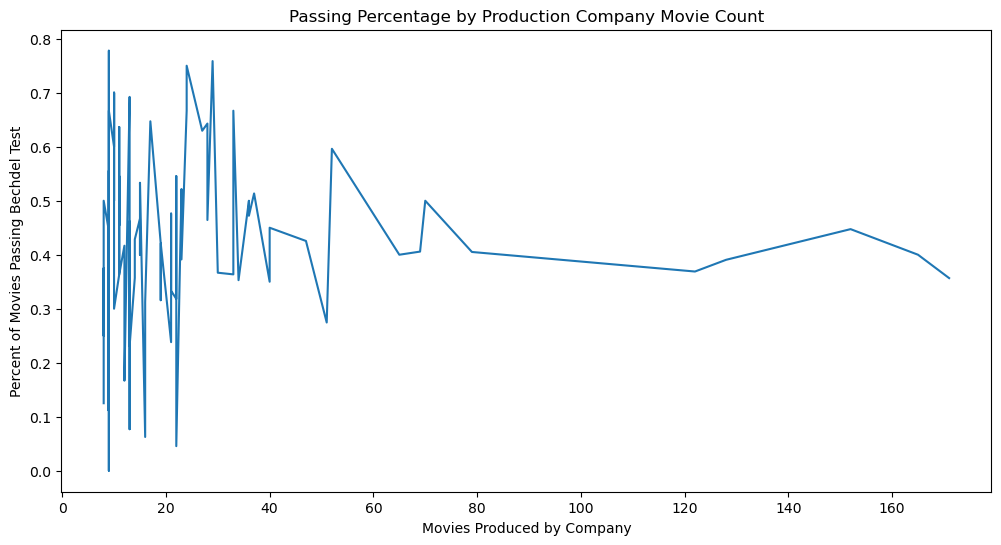

In [131]:
plt.plot(prod_passing.movie_count, prod_passing.perc_passing)
plt.title("Passing Percentage by Production Company Movie Count")
plt.xlabel("Movies Produced by Company")
plt.ylabel("Percent of Movies Passing Bechdel Test")

In [132]:
res = execute_query("""
    SELECT COUNT(*) AS movie_count,
           prod_comps,
           SUM(CASE WHEN g.binary_PASS = 1 THEN 1 ELSE 0 END) / COUNT(*) AS perc_passing
    FROM production_company pc
    JOIN general g ON pc.imdb = g.imdb
    GROUP BY prod_comps
    HAVING perc_passing = 1
    ORDER BY movie_count DESC;
""")
prod_passing = pd.DataFrame(res)
print("Production companies with 100% pass rate, by movie count\n")
prod_passing

Production companies with 100% pass rate, by movie count



,movie_count,prod_comps,perc_passing
0,6,Fortis Films,1.0000
1,5,Thin Man Films,1.0000
2,4,Fine Line Features,1.0000
3,4,Craven-Maddalena Films,1.0000
4,4,HBO Films,1.0000
...,...,...,...
816,1,Hopscotch Features,1.0000
817,1,Essential Media and Entertainment,1.0000
818,1,Translux,1.0000
819,1,Nephilim Producciones,1.0000


#### Genre Analysis

In [133]:
res = execute_query("""
    SELECT COUNT(*) AS movie_count,
           genres,
           SUM(CASE WHEN g.binary_PASS = 1 THEN 1 ELSE 0 END) / COUNT(*) AS perc_passing
    FROM genre gn
    JOIN general g ON gn.imdb = g.imdb
    GROUP BY genres
    ORDER BY movie_count DESC;
""")
genre_passing = pd.DataFrame(res)
print("Passing percentages by genre\n")
genre_passing.sort_values(by=['perc_passing'], ascending=False)

Passing percentages by genre



,movie_count,genres,perc_passing
5,321,Romance,0.6012
10,193,Horror,0.5959
15,50,Music,0.5800
1,637,Comedy,0.4835
0,763,Drama,0.4823
9,199,Family,0.4724
13,70,History,0.4714
11,151,Mystery,0.4702
8,233,Fantasy,0.4378
3,461,Thriller,0.3774


#### Clean_test Analysis
Note that only values of 'ok' indicate a pass in the binary_PASS column

In [134]:
res = execute_query("""
    SELECT COUNT(*) AS movie_count,
           clean_test
    FROM general g
    GROUP BY clean_test
    ORDER BY movie_count DESC;
""")
clean_test_freq = pd.DataFrame(res)
print("Frequencies for clean_test classifications\n")
clean_test_freq.sort_values(by=['movie_count'], ascending=False)

Frequencies for clean_test classifications



,movie_count,clean_test
0,767,ok
1,502,notalk
2,188,men
3,137,dubious
4,136,nowomen


# Text Analysis

In [72]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [73]:
data = pd.read_csv("bechdel_analysis_data_cleaned.csv", float_precision=None)
data

,year,imdb,title,clean_test,budget_2013$,binary_PASS,domgross_2013$,genres,prod_comps,overview,perc_women_producers,perc_women_directors
0,2013,tt1711425,21 &amp; Over,notalk,13000000,0,25682380.0,['Comedy'],"['Mandeville Films', 'Relativity Media', 'SkyL...",Brilliant student Jeff Chang has the most impo...,0.00,0.0
1,2012,tt1343727,Dredd 3D,ok,45658735,1,13611086.0,"['Action', 'Science Fiction']","['Rena Film', 'DNA Films', 'Reliance Big Enter...","In the future, America is a dystopian wastelan...",0.00,0.0
2,2013,tt2024544,12 Years a Slave,notalk,20000000,0,53107035.0,"['Drama', 'History']","['New Regency Pictures', 'Plan B Entertainment...","In the pre-Civil War United States, Solomon No...",0.25,0.0
3,2013,tt1272878,2 Guns,notalk,61000000,0,75612460.0,"['Action', 'Comedy', 'Crime']","['Universal Pictures', 'Marc Platt Productions...",A DEA agent and an undercover Naval Intelligen...,0.00,0.0
4,2013,tt0453562,42,men,40000000,0,95020213.0,['Drama'],"['Warner Bros. Pictures', 'Legendary Pictures']","The powerful story of Jackie Robinson, the leg...",0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1725,1971,tt0067741,Shaft,notalk,305063707,0,404702718.0,"['Action', 'Crime', 'Thriller']","['Shaft Productions', 'Metro-Goldwyn-Mayer']",Cool black private eye John Shaft is hired by ...,0.00,0.0
1726,1971,tt0067800,Straw Dogs,notalk,143862856,0,59412143.0,"['Crime', 'Drama', 'Thriller']",['ABC Pictures'],"David Sumner, a mild-mannered academic from th...",0.00,0.0
1727,1971,tt0067116,The French Connection,notalk,12659931,0,236848653.0,"['Action', 'Crime', 'Thriller']","[""D'Antoni Productions"", 'Schine-Moore Product...",Tough narcotics detective 'Popeye' Doyle is in...,0.00,0.0
1728,1971,tt0067992,Willy Wonka &amp; the Chocolate Factory,men,17263543,0,23018057.0,"['Family', 'Fantasy', 'Comedy']",['David L. Wolper Productions'],When eccentric candy man Willy Wonka promises ...,0.00,0.0


In [74]:
vectorizer = CountVectorizer()
overviews_bag = vectorizer.fit_transform(data["overview"])
titles_bag = vectorizer.fit_transform(data["title"])

In [75]:
vectorizer.get_feature_names_out()

array(['10', '12', '123', ..., 'zoom', 'zorro', 'zwartboek'], dtype=object)

In [76]:
type(overviews_bag.toarray())
overviews_bag.toarray()[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

#### Prediction Using Bag of Words on Movie Overview

In [77]:

X = overviews_bag.toarray()
y = data["binary_PASS"]

X_train, X_test, y_train, y_test = train_test_split(X, y)
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr', max_iter=300)

In [78]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)


In [79]:
metrics.accuracy_score(y_test, y_pred)

0.6605080831408776

#### Prediction TF-IDF on Movie Overview

In [80]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(data["overview"])
df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names_out(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head())
len(df)

              TF-IDF
debauchery  0.248478
evolves     0.248478
chang       0.248478
casual      0.235501
derail      0.235501


12036

In [81]:
X = tfIdf.toarray()
y = data["binary_PASS"]

X_train, X_test, y_train, y_test = train_test_split(X, y)
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr')

In [82]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [83]:
metrics.accuracy_score(y_test, y_pred)

0.6928406466512702

#### Prediction Using Bag of Words on Movie Title

In [84]:
X = titles_bag.toarray()
y = data["binary_PASS"]

X_train, X_test, y_train, y_test = train_test_split(X, y)
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr')

In [85]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

C:\Users\tyguy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [86]:
metrics.accuracy_score(y_test, y_pred)

0.5681293302540416

#### Prediction Using TF-IDF on Movie Title

In [87]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(data["title"])
df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names_out(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head())


           TF-IDF
over     0.625321
21       0.625321
amp      0.466849
planner  0.000000
place    0.000000


In [88]:
X = tfIdf.toarray()
y = data["binary_PASS"]

X_train, X_test, y_train, y_test = train_test_split(X, y)
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr', max_iter=100)

In [89]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

C:\Users\tyguy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [90]:
metrics.accuracy_score(y_test, y_pred)

0.6004618937644342

#### Conclusions
- The movie overview was a much better predictor for passing the bechdel test, mainly because the overview simply contains more data. Each summary has multiple sentences of data, as opposed to just a few words for the title.
- The TF-IDF approach worked slightly better than the bag of words. 

# Predictive Modeling

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, tree, neighbors, linear_model, ensemble, naive_bayes, svm, neural_network
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, mean_squared_error, accuracy_score
import math

In [93]:
data = pd.read_csv("bechdel_analysis_data_cleaned_with_genres.csv", float_precision=None)
data

,Unnamed: 0,year,imdb,title,clean_test,budget_2013$,binary_PASS,domgross_2013$,intgross_2013$,adult,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,0,2013,tt1711425,21 &amp; Over,notalk,13000000,0,25682380.0,42195766.0,False,...,0,0,0,0,0,0,0,0,0,0
1,1,2012,tt1343727,Dredd 3D,ok,45658735,1,13611086.0,41467257.0,False,...,0,0,0,0,0,0,1,0,0,0
2,2,2013,tt2024544,12 Years a Slave,notalk,20000000,0,53107035.0,158607035.0,False,...,0,1,0,0,0,0,0,0,0,0
3,3,2013,tt1272878,2 Guns,notalk,61000000,0,75612460.0,132493015.0,False,...,0,0,0,0,0,0,0,0,0,0
4,4,2013,tt0453562,42,men,40000000,0,95020213.0,95020213.0,False,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725,1725,1971,tt0067741,Shaft,notalk,305063707,0,404702718.0,616827003.0,False,...,0,0,0,0,0,0,0,1,0,0
1726,1726,1971,tt0067800,Straw Dogs,notalk,143862856,0,59412143.0,64760273.0,False,...,0,0,0,0,0,0,0,1,0,0
1727,1727,1971,tt0067116,The French Connection,notalk,12659931,0,236848653.0,236848653.0,False,...,0,0,0,0,0,0,0,1,0,0
1728,1728,1971,tt0067992,Willy Wonka &amp; the Chocolate Factory,men,17263543,0,23018057.0,23018057.0,False,...,1,0,0,0,0,0,0,0,0,0


In [94]:
genre_data = data.genres
prod_comp_data = data.prod_comps
overview_data = data.overview

data = data.drop(['genres', 'prod_comps', 'overview', 'title', 'imdb'], axis=1)

In [95]:
Y = data.binary_PASS
data = data.drop(['binary_PASS', 'clean_test'], axis=1)
X = data

In [96]:
X

,Unnamed: 0,year,budget_2013$,domgross_2013$,intgross_2013$,adult,perc_women_producers,perc_women_directors,Action,Adventure,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,0,2013,13000000,25682380.0,42195766.0,False,0.00,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2012,45658735,13611086.0,41467257.0,False,0.00,0.0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,2,2013,20000000,53107035.0,158607035.0,False,0.25,0.0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,3,2013,61000000,75612460.0,132493015.0,False,0.00,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4,2013,40000000,95020213.0,95020213.0,False,0.00,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725,1725,1971,305063707,404702718.0,616827003.0,False,0.00,0.0,1,0,...,0,0,0,0,0,0,0,1,0,0
1726,1726,1971,143862856,59412143.0,64760273.0,False,0.00,0.0,0,0,...,0,0,0,0,0,0,0,1,0,0
1727,1727,1971,12659931,236848653.0,236848653.0,False,0.00,0.0,1,0,...,0,0,0,0,0,0,0,1,0,0
1728,1728,1971,17263543,23018057.0,23018057.0,False,0.00,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [97]:
Y

0       0
1       1
2       0
3       0
4       0
       ..
1725    0
1726    0
1727    0
1728    0
1729    1
Name: binary_PASS, Length: 1730, dtype: int64

In [98]:
# Question 1.a.i - Decision Tree Classifier
dt_accuracy = {1: None, 5: None, 10: None, 50: None, 100: None}
for i in dt_accuracy:
    # Train decision tree classifier with given max_depth
    dt_clf = tree.DecisionTreeClassifier(max_depth=i)
    dt_accuracy[i] = cross_val_score(dt_clf, X, Y, cv=5).mean()
    

In [99]:
# Question 1.a.ii - K-nearest Neighbor
knn_accuracy = {1: None, 2: None, 3: None, 4: None, 5: None, 10: None, 15: None}
for i in knn_accuracy:
    # Train k-nearest neigbor classifier with given n_neighbors
    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=i)
    knn_accuracy[i] = cross_val_score(knn_clf, X, Y, cv=5).mean()

In [100]:
# Logistic Regression
lr_accuracy = {0.001: None, 0.01: None, 0.1: None, 0.5: None, 1: None}
for i in lr_accuracy:
    # Train logistic regression classifier with given C
    lr_clf = linear_model.LogisticRegression(C=i)
    lr_accuracy[i] = cross_val_score(lr_clf, X, Y, cv=5).mean()

In [101]:
# Naive Bayes
nb_accuracy = {0.001: None, 0.01: None, 0.1: None, 0.5: None, 1: None}
for i in nb_accuracy:
    # Train naive bayes classifier with given alpha
    nb_clf = naive_bayes.ComplementNB(alpha=i)
    nb_accuracy[i] = cross_val_score(nb_clf, X, Y, cv=5).mean()

In [102]:
# Support Vector Machine
sv_accuracy = {0.001: None, 0.01: None, 0.1: None, 0.5: None, 1: None}
for i in sv_accuracy:
    # Train support vector classifier with given C
    sv_clf = svm.SVC(C=i)
    sv_accuracy[i] = cross_val_score(sv_clf, X, Y, cv=5).mean()

In [103]:
# Multilayer Perceptron Classifier (NN)
mlp_accuracy = {10: None, 25: None, 50: None, 75: None, 100: None}
for i in mlp_accuracy:
    # Train multilayer perceptron classifier with given 
    mlp_clf = neural_network.MLPClassifier(hidden_layer_sizes=(i,))
    mlp_accuracy[i] = cross_val_score(mlp_clf, X, Y, cv=5).mean()

In [104]:
# Random Forest
rf_accuracy = {10: None, 25: None, 50: None, 100: None, 150: None}
for i in rf_accuracy:
    # Train random forest classifier with given n_estimators
    rf_clf = ensemble.RandomForestClassifier(n_estimators=i)
    rf_accuracy[i] = cross_val_score(rf_clf, X, Y, cv=5).mean()

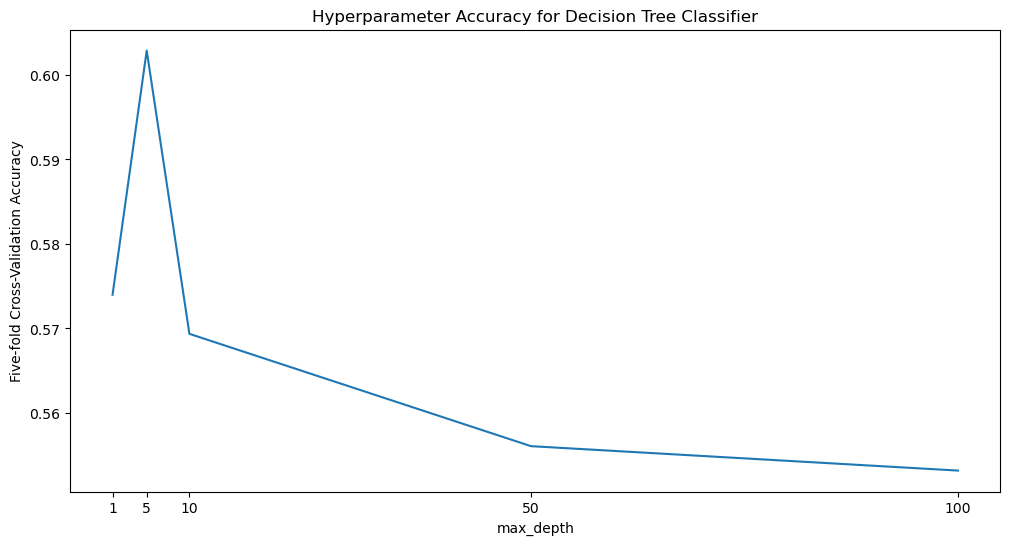

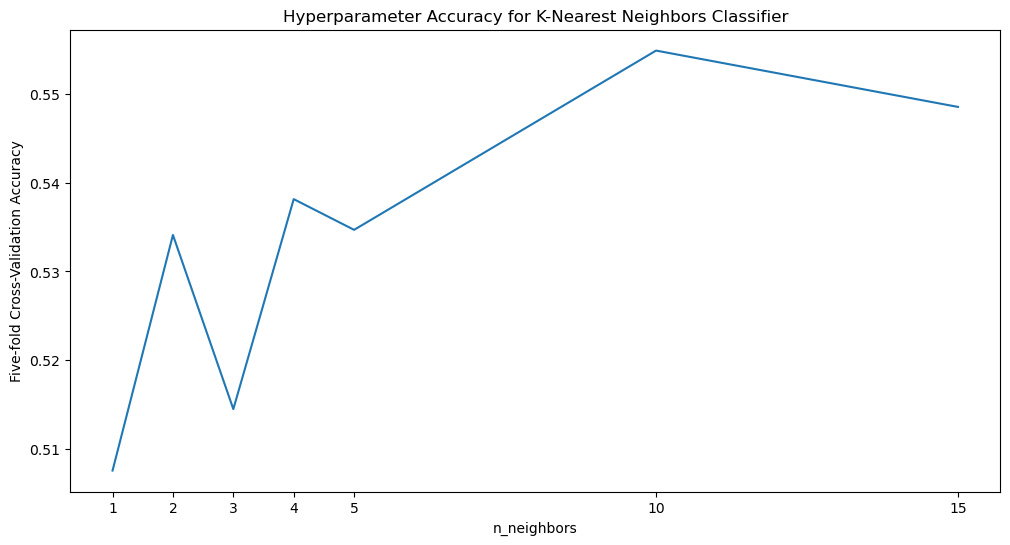

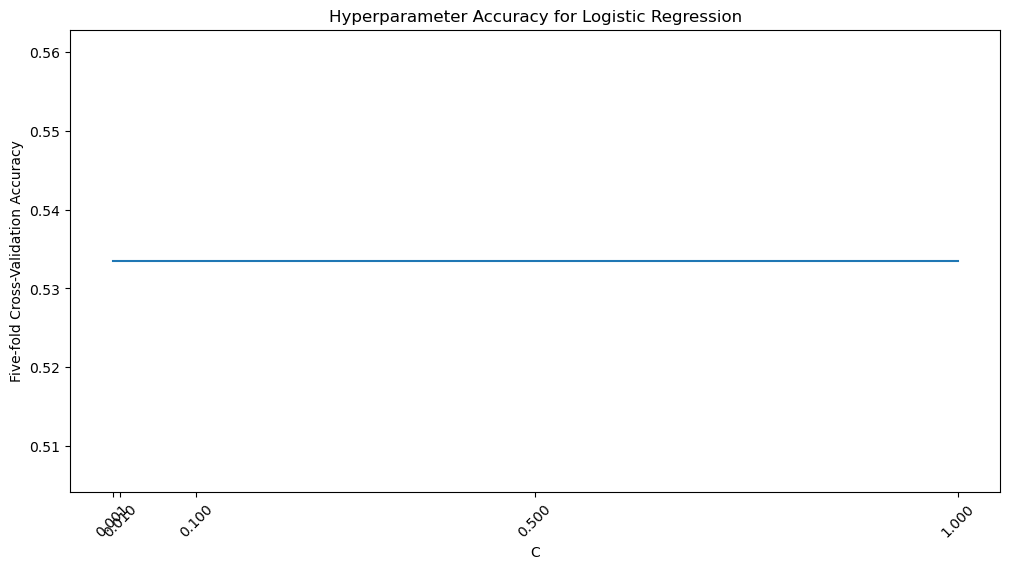

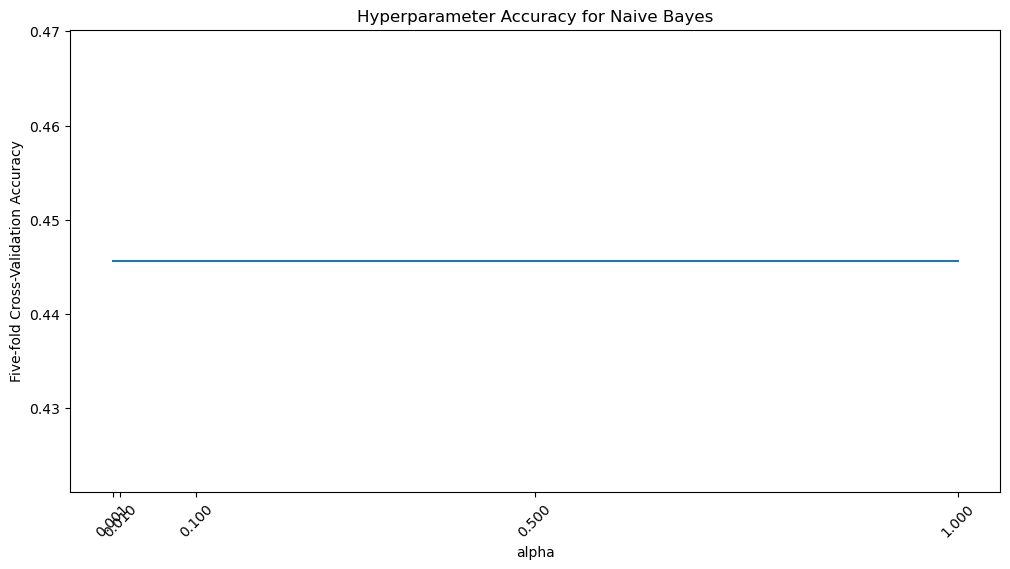

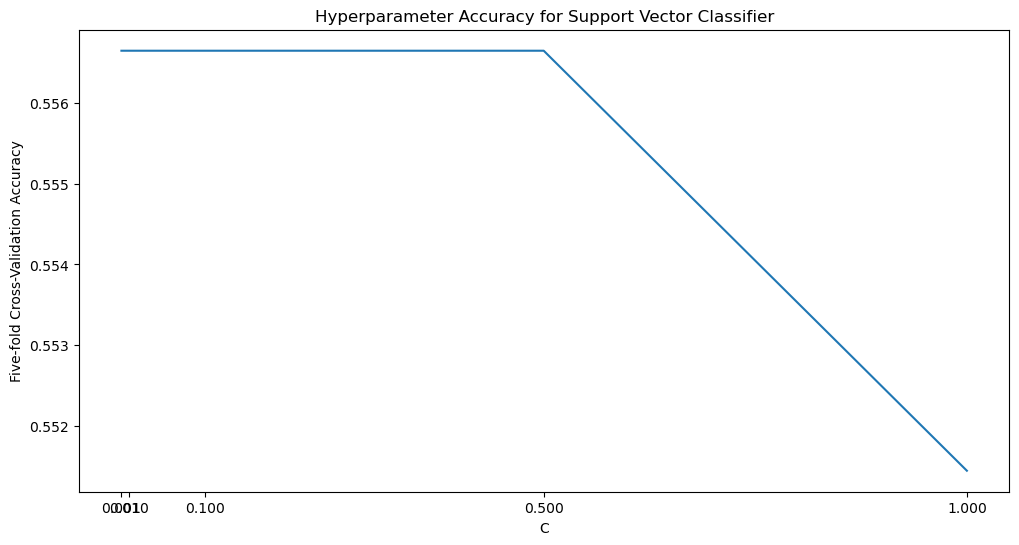

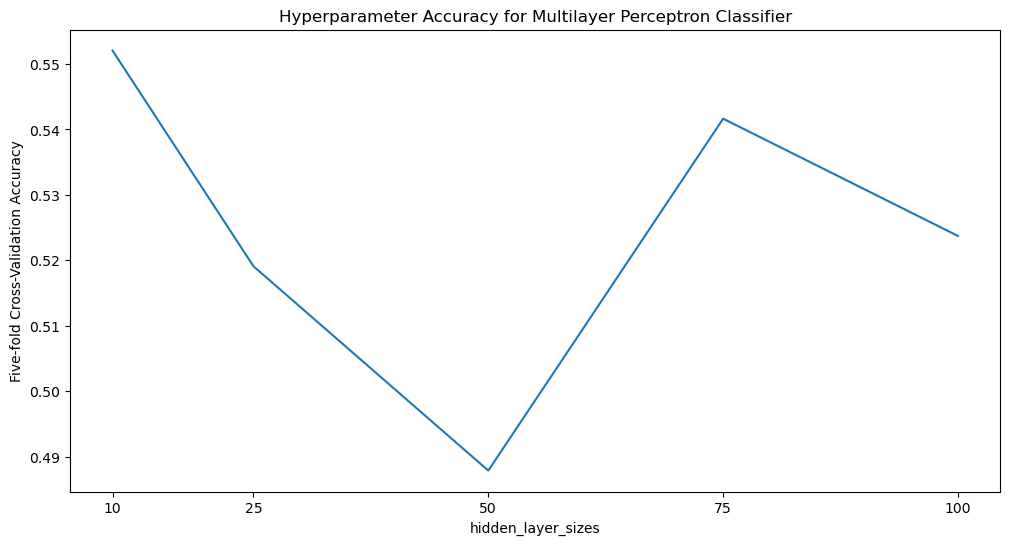

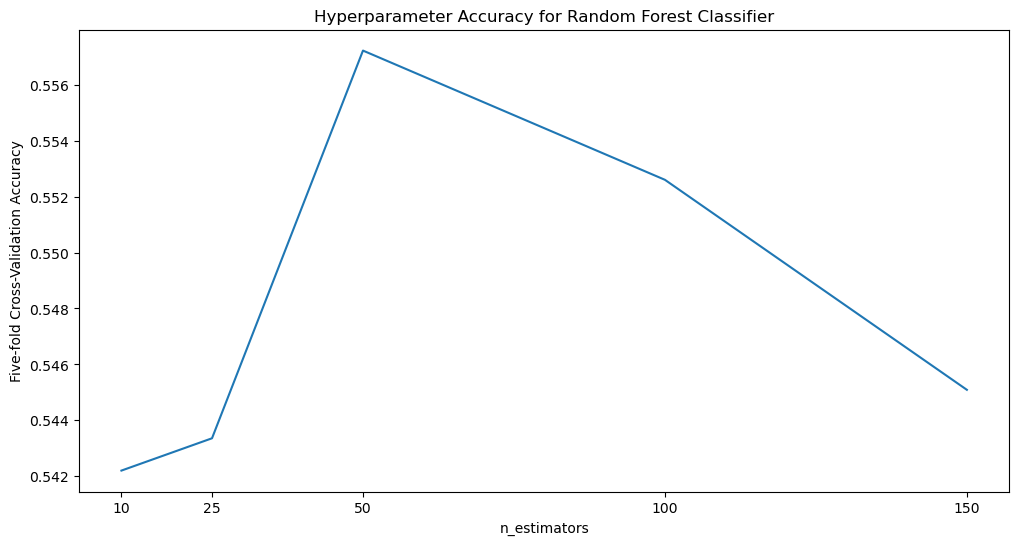

In [105]:
plt.figure()
plt.title("Hyperparameter Accuracy for Decision Tree Classifier")
plt.plot()
x = [i for i in dt_accuracy.keys()]
y = [i for i in dt_accuracy.values()]

plt.plot(x,y)
plt.xticks(x)
plt.ylabel("Five-fold Cross-Validation Accuracy")
plt.xlabel("max_depth")
plt.show()

plt.figure()
plt.title("Hyperparameter Accuracy for K-Nearest Neighbors Classifier")
x = [i for i in knn_accuracy.keys()]
y = [i for i in knn_accuracy.values()]

plt.plot(x,y)
plt.xticks(x)
plt.ylabel("Five-fold Cross-Validation Accuracy")
plt.xlabel("n_neighbors")
plt.show()

plt.figure()
plt.title("Hyperparameter Accuracy for Logistic Regression")
x = [i for i in lr_accuracy.keys()]
y = [i for i in lr_accuracy.values()]

plt.plot(x,y)
plt.xticks(x, rotation=45)
plt.ylabel("Five-fold Cross-Validation Accuracy")
plt.xlabel("C")
plt.show()

plt.figure()
plt.title("Hyperparameter Accuracy for Naive Bayes")
x = [i for i in nb_accuracy.keys()]
y = [i for i in nb_accuracy.values()]

plt.plot(x,y)
plt.xticks(x, rotation=45)
plt.ylabel("Five-fold Cross-Validation Accuracy")
plt.xlabel("alpha")
plt.show()

plt.figure()
plt.title("Hyperparameter Accuracy for Support Vector Classifier")
plt.plot()
x = [i for i in sv_accuracy.keys()]
y = [i for i in sv_accuracy.values()]

plt.plot(x,y)
plt.xticks(x)
plt.ylabel("Five-fold Cross-Validation Accuracy")
plt.xlabel("C")
plt.show()

plt.figure()
plt.title("Hyperparameter Accuracy for Multilayer Perceptron Classifier")
plt.plot()
x = [i for i in mlp_accuracy.keys()]
y = [i for i in mlp_accuracy.values()]

plt.plot(x,y)
plt.xticks(x)
plt.ylabel("Five-fold Cross-Validation Accuracy")
plt.xlabel("hidden_layer_sizes")
plt.show()

plt.figure()
plt.title("Hyperparameter Accuracy for Random Forest Classifier")
plt.plot()
x = [i for i in rf_accuracy.keys()]
y = [i for i in rf_accuracy.values()]

plt.plot(x,y)
plt.xticks(x)
plt.ylabel("Five-fold Cross-Validation Accuracy")
plt.xlabel("n_estimators")
plt.show()

[Text(0.5, 0.75, 'Action <= 0.5\ngini = 0.494\nsamples = 1730\nvalue = [963, 767]\nclass = b'),
 Text(0.25, 0.25, 'gini = 0.5\nsamples = 1242\nvalue = [610, 632]\nclass = i'),
 Text(0.75, 0.25, 'gini = 0.4\nsamples = 488\nvalue = [353, 135]\nclass = b')]

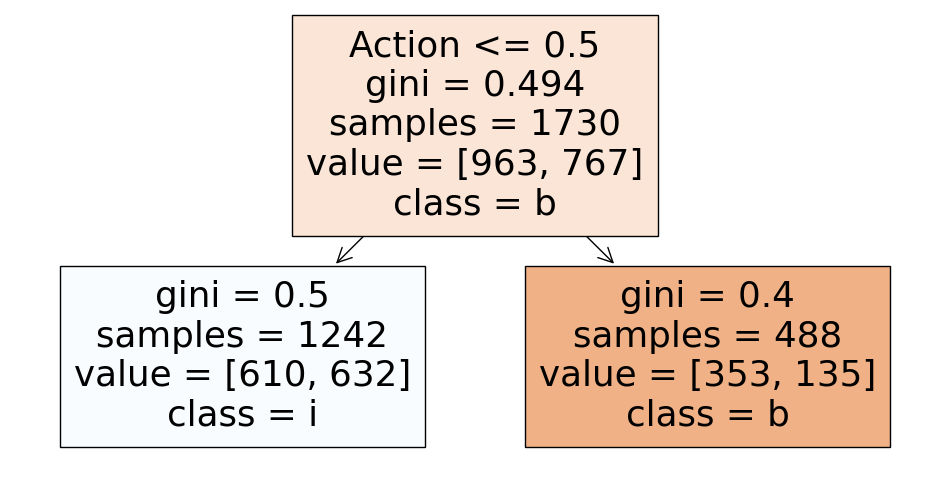

In [106]:
dt_clf = tree.DecisionTreeClassifier(max_depth=1)
dt_clf.fit(X, Y)
tree.plot_tree(dt_clf, feature_names=[i for i in X.columns], class_names='binary_PASS',filled=True)

In [107]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# Train DT
dt_clf = tree.DecisionTreeClassifier(max_depth=1)
dt_clf.fit(x_train, y_train)
dt_pred = dt_clf.predict(x_test)

# Train KNN
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=10)
knn_clf.fit(x_train, y_train)
knn_pred = knn_clf.predict(x_test)

# Train LR
lr_clf = linear_model.LogisticRegression(C=0.5)
lr_clf.fit(x_train, y_train)
lr_pred = lr_clf.predict(x_test)

# Train NB
nb_clf = naive_bayes.ComplementNB(alpha=0.5)
nb_clf.fit(x_train, y_train)
nb_pred = nb_clf.predict(x_test)

# Train SVC
sv_clf = svm.SVC(C=0.5, probability=True)
sv_clf.fit(x_train, y_train)
sv_pred = sv_clf.predict(x_test)

# Train MLP
mlp_clf = neural_network.MLPClassifier(hidden_layer_sizes=(50,))
mlp_clf.fit(x_train, y_train)
mlp_pred = mlp_clf.predict(x_test)

# Train RF
rf_clf = ensemble.RandomForestClassifier(n_estimators=10)
rf_clf.fit(x_train, y_train)
rf_pred = rf_clf.predict(x_test)

In [108]:
# Calculate confusion matrix
dt_conf_mat = confusion_matrix(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)

knn_conf_mat = confusion_matrix(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)

lr_conf_mat = confusion_matrix(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)

nb_conf_mat = confusion_matrix(y_test, nb_pred)
nb_f1 = f1_score(y_test, nb_pred)

sv_conf_mat = confusion_matrix(y_test, sv_pred)
sv_f1 = f1_score(y_test, sv_pred)

mlp_conf_mat = confusion_matrix(y_test, mlp_pred)
mlp_f1 = f1_score(y_test, mlp_pred)

rf_conf_mat = confusion_matrix(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

# Print output
print("Decision Tree Confusion Matrix")
print(dt_conf_mat)
print("K-Nearest Neighbor Confusion Matrix")
print(knn_conf_mat)
print("Logistic Regression Confusion Matrix")
print(lr_conf_mat)
print("Naive Bayes Confusion Matrix")
print(nb_conf_mat)
print("SVC Confusion Matrix")
print(sv_conf_mat)
print("Multilayer Perceptron Confusion Matrix")
print(mlp_conf_mat)
print("Random Forest Confusion Matrix")
print(rf_conf_mat)

Decision Tree Confusion Matrix
[[ 58 138]
 [ 27 123]]
K-Nearest Neighbor Confusion Matrix
[[150  46]
 [ 95  55]]
Logistic Regression Confusion Matrix
[[194   2]
 [149   1]]
Naive Bayes Confusion Matrix
[[131  65]
 [106  44]]
SVC Confusion Matrix
[[196   0]
 [150   0]]
Multilayer Perceptron Confusion Matrix
[[98 98]
 [77 73]]
Random Forest Confusion Matrix
[[140  56]
 [ 82  68]]


In [109]:
# Question 1.d.ii
# Precision, recall for Decision Tree
dt_p = (dt_conf_mat[0][0]/(dt_conf_mat[0][0] + dt_conf_mat[1][0]))
dt_r = (dt_conf_mat[0][0]/(dt_conf_mat[0][0] + dt_conf_mat[0][1]))

# Precision, recall for K-Nearest Neighbor
knn_p = (knn_conf_mat[0][0]/(knn_conf_mat[0][0] + knn_conf_mat[1][0]))
knn_r = (knn_conf_mat[0][0]/(knn_conf_mat[0][0] + knn_conf_mat[0][1]))

# Precision, recall for Logistic Regression
lr_p = (lr_conf_mat[0][0]/(lr_conf_mat[0][0] + lr_conf_mat[1][0]))
lr_r = (lr_conf_mat[0][0]/(lr_conf_mat[0][0] + lr_conf_mat[0][1]))

# Precision, recall for Naive Bayes
nb_p = (nb_conf_mat[0][0]/(nb_conf_mat[0][0] + nb_conf_mat[1][0]))
nb_r = (nb_conf_mat[0][0]/(nb_conf_mat[0][0] + nb_conf_mat[0][1]))

# Precision, recall for Support Vector Machine
sv_p = (sv_conf_mat[0][0]/(sv_conf_mat[0][0] + sv_conf_mat[1][0]))
sv_r = (sv_conf_mat[0][0]/(sv_conf_mat[0][0] + sv_conf_mat[0][1]))

# Precision, recall for Multilayer Perceptron
mlp_p = (mlp_conf_mat[0][0]/(mlp_conf_mat[0][0] + mlp_conf_mat[1][0]))
mlp_r = (mlp_conf_mat[0][0]/(mlp_conf_mat[0][0] + mlp_conf_mat[0][1]))

# Precision, recall for Random Forest Classifier
rf_p = (rf_conf_mat[0][0]/(rf_conf_mat[0][0] + rf_conf_mat[1][0]))
rf_r = (rf_conf_mat[0][0]/(rf_conf_mat[0][0] + rf_conf_mat[0][1]))

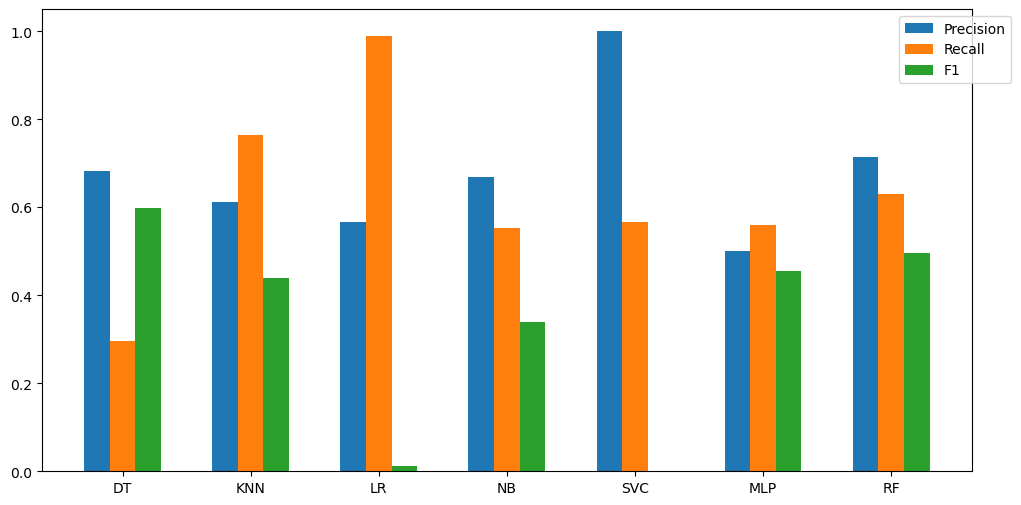

In [110]:
# Generate output
classifiers = ['DT', 'KNN', 'LR', 'NB', 'SVC', 'MLP', 'RF']
precisions = [dt_p, knn_p, lr_p, nb_r, sv_r, mlp_r, rf_r]
recalls = [dt_r, knn_r, lr_r, nb_p, sv_p, mlp_p, rf_p]
f1s = [dt_f1, knn_f1, lr_f1, nb_f1, sv_f1, mlp_f1, rf_f1]
x_axis= np.arange(len(classifiers))

plt.figure()
plt.bar(x_axis-0.2, precisions, width=0.2, label="Precision")
plt.bar(x_axis, recalls, width=0.2, label="Recall")
plt.bar(x_axis+0.2, f1s, width=0.2, label="F1")

plt.xticks(x_axis, classifiers)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()


In [111]:
# Question 1.d.iii

# DT Stats
dt_prob = dt_clf.predict_proba(x_test)
dt_labels = (y_test == 1)

dt_fpr, dt_tpr, dt_thresh = roc_curve(dt_labels, dt_prob[:,1])
dt_roc_auc = auc(dt_fpr, dt_tpr)
dt_legend = "DT (AUC = %0.4f)" % dt_roc_auc

# KNN Stats
knn_prob = knn_clf.predict_proba(x_test)
knn_labels = (y_test == 1)

knn_fpr, knn_tpr, knn_thresh = roc_curve(knn_labels, knn_prob[:,1])
knn_roc_auc = auc(knn_fpr, knn_tpr)
knn_legend = "KNN (AUC = %0.4f)" % knn_roc_auc

# LR Stats
lr_prob = lr_clf.predict_proba(x_test)
lr_labels = (y_test == 1)

lr_fpr, lr_tpr, lr_thresh = roc_curve(lr_labels, lr_prob[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)
lr_legend = "LR (AUC = %0.4f)" % lr_roc_auc

# NB Stats
nb_prob = nb_clf.predict_proba(x_test)
nb_labels = (y_test == 1)

nb_fpr, nb_tpr, nb_thresh = roc_curve(nb_labels, nb_prob[:,1])
nb_roc_auc = auc(nb_fpr, nb_tpr)
nb_legend = "NB (AUC = %0.4f)" % nb_roc_auc

# SVC Stats
sv_prob = sv_clf.predict_proba(x_test)
sv_labels = (y_test == 1)

sv_fpr, sv_tpr, sv_thresh = roc_curve(sv_labels, sv_prob[:,1])
sv_roc_auc = auc(sv_fpr, sv_tpr)
sv_legend = "SV (AUC = %0.4f)" % sv_roc_auc

# MLP Stats
mlp_prob = mlp_clf.predict_proba(x_test)
mlp_labels = (y_test == 1)

mlp_fpr, mlp_tpr, mlp_thresh = roc_curve(mlp_labels, mlp_prob[:,1])
mlp_roc_auc = auc(mlp_fpr, mlp_tpr)
mlp_legend = "MLP (AUC = %0.4f)" % mlp_roc_auc

# SVC Stats
rf_prob = rf_clf.predict_proba(x_test)
rf_labels = (y_test == 1)

rf_fpr, rf_tpr, rf_thresh = roc_curve(rf_labels, rf_prob[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)
rf_legend = "RF (AUC = %0.4f)" % rf_roc_auc

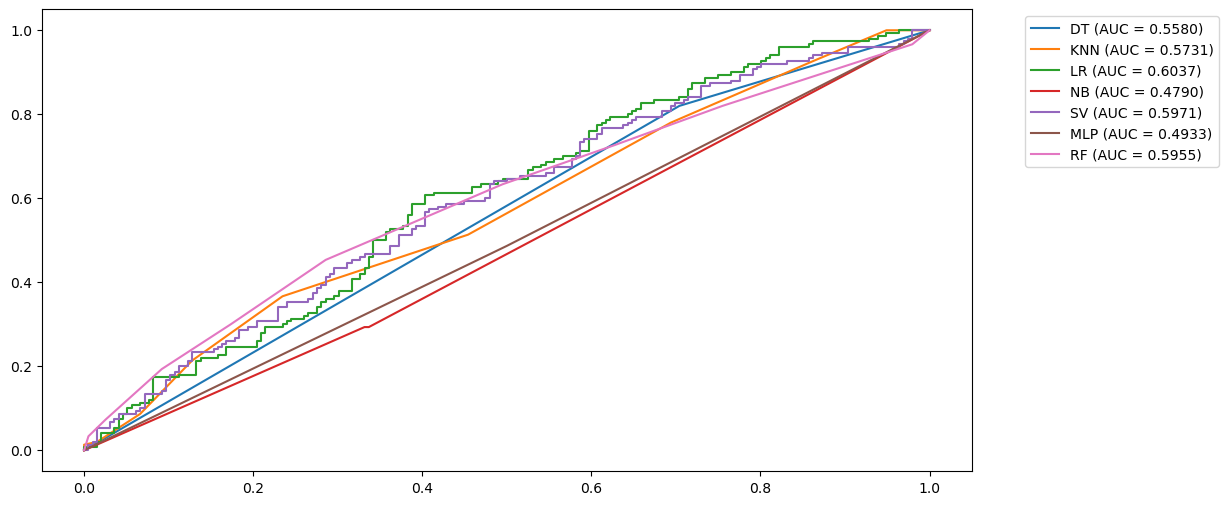

In [112]:
# Make AUC plot
plt.figure()

plt.plot(dt_fpr, dt_tpr, label=dt_legend)
plt.plot(knn_fpr, knn_tpr, label=knn_legend)
plt.plot(lr_fpr, lr_tpr, label=lr_legend)
plt.plot(nb_fpr, nb_tpr, label=nb_legend)
plt.plot(sv_fpr, sv_tpr, label=sv_legend)
plt.plot(mlp_fpr, mlp_tpr, label=mlp_legend)
plt.plot(rf_fpr, rf_tpr, label=rf_legend)

plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

## Interesting Observations
Observations here

## Brute Force - GridSearch

In [113]:
# Decision Tree
dt_params = {'criterion': ['gini', 'entropy'],'splitter': ['best', 'random'], 'max_depth': [None, 1, 5, 10, 50], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 5, 10]}

dt = tree.DecisionTreeClassifier()

dt_grid_search = GridSearchCV(estimator=dt, param_grid=dt_params, cv=5, n_jobs=-1,
                          verbose=1, scoring='accuracy')

dt_grid_search.fit(X, Y)

dt_grid_search.best_estimator_

Fitting 5 folds for each of 180 candidates, totalling 900 fits


DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5,
                       splitter='random')

In [114]:
# K-Nearest Neighbors
knn_params = {'n_neighbors': [1, 3, 5, 10, 50], 
              'weights': ['uniform', 'distance'], 
              'algorithm': ['ball_tree', 'kd_tree', 'brute'], 
              'leaf_size': [5, 10, 30, 50]}

knn = neighbors.KNeighborsClassifier()

knn_grid_search = GridSearchCV(estimator=knn, param_grid=knn_params, cv=5, n_jobs=-1,
                          verbose=1, scoring='accuracy')

knn_grid_search.fit(X, Y)

knn_grid_search.best_estimator_

Fitting 5 folds for each of 120 candidates, totalling 600 fits


KNeighborsClassifier(algorithm='ball_tree', leaf_size=5, n_neighbors=10)

In [115]:
# Logisitic Regression
lr_params = {'C': [0.001, 0.01, 0.1, 0.5, 1], 
              'solver': ['liblinear', 'lbfgs', 'newton-cholesky'], 
              'penalty': ['l1', 'l2', 'elasticnet', None]}

lr = linear_model.LogisticRegression()

lr_grid_search = GridSearchCV(estimator=lr, param_grid=lr_params, cv=5, n_jobs=-1,
                          verbose=1, scoring='accuracy')

lr_grid_search.fit(X, Y)

lr_grid_search.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


C:\Users\tyguy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\tyguy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tyguy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\tyguy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    raise ValueError(
Val

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [116]:
# Naive Bayes
nb_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 1.5], 
              'norm': [True, False]}


nb = naive_bayes.ComplementNB()

nb_grid_search = GridSearchCV(estimator=nb, param_grid=nb_params, cv=5, n_jobs=-1,
                          verbose=1, scoring='accuracy')

nb_grid_search.fit(X, Y)

nb_grid_search.best_estimator_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


ComplementNB(alpha=1, norm=True)

In [117]:
# # Support Vector Machine
# sv_params = {'C': [0.001, 0.01, 0.1, 0.5, 1], 
#               'kernel': ['linear', 'poly', 'rbf']}
# # , 
# #               'gamma': ['scale', 'auto']}


# sv = svm.SVC(probability=True)

# sv_grid_search = GridSearchCV(estimator=sv, param_grid=sv_params, cv=5, n_jobs=-1,
#                           verbose=1, scoring='accuracy')

# sv_grid_search.fit(X, Y)

# sv_grid_search.best_estimator_

In [118]:
# Multilayer Perceptron
mlp_params = {'hidden_layer_sizes': [(10,), (25,), (50,), (100,)],
              'activation': ['logistic', 'relu', 'identity'],
              'solver': ['lbfgs', 'sgd', 'adam'],
              'learning_rate': ['constant', 'adaptive'],
              'alpha': [0.0001, 0.001, 0.01]}

mlp = neural_network.MLPClassifier()

mlp_grid_search = GridSearchCV(estimator=mlp, param_grid=mlp_params, cv=5, n_jobs=-1,
                          verbose=1, scoring='accuracy')

mlp_grid_search.fit(X, Y)

mlp_grid_search.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\tyguy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\tyguy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tyguy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 742, in fit
    return self._fit(X, y, incremental=False)
  File "C:\Users\tyguy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 486, in _fit
    raise ValueError(

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(10,),
              learning_rate='adaptive', solver='sgd')

In [119]:
# Random Forest
params = {'n_estimators': [10, 25, 50, 100], 
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 1, 5, 10, 50],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 5, 10]}

rf = ensemble.RandomForestClassifier()

rf_grid_search = GridSearchCV(estimator=rf, param_grid=params, cv=5, n_jobs=-1,
                          verbose=1, scoring='accuracy')

rf_grid_search.fit(X, Y)

rf_grid_search.best_estimator_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=10)

In [120]:
# Decision Tree
# Predict labels
dt_best = dt_grid_search.best_estimator_
dt_pred = dt_best.predict(x_test)

# Confusion matrix and F1 score
dt_conf_mat = confusion_matrix(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)

# Precision and recall
dt_p = (dt_conf_mat[0][0]/(dt_conf_mat[0][0] + dt_conf_mat[1][0]))
dt_r = (dt_conf_mat[0][0]/(dt_conf_mat[0][0] + dt_conf_mat[0][1]))

# DT stats
dt_prob = dt_best.predict_proba(x_test)
dt_labels = (y_test == 1)

dt_fpr, dt_tpr, dt_thresh = roc_curve(dt_labels, dt_prob[:,1])
dt_roc_auc = auc(dt_fpr, dt_tpr)
dt_legend = "RF (AUC = %0.4f)" % dt_roc_auc

# K-Nearest Neighbors
# Predict labels
knn_best = knn_grid_search.best_estimator_
knn_pred = knn_best.predict(x_test)

# Confusion matrix and F1 score
knn_conf_mat = confusion_matrix(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)

# Precision and recall
knn_p = (knn_conf_mat[0][0]/(knn_conf_mat[0][0] + knn_conf_mat[1][0]))
knn_r = (knn_conf_mat[0][0]/(knn_conf_mat[0][0] + knn_conf_mat[0][1]))

# KNN stats
knn_prob = knn_best.predict_proba(x_test)
knn_labels = (y_test == 1)

knn_fpr, knn_tpr, knn_thresh = roc_curve(knn_labels, knn_prob[:,1])
knn_roc_auc = auc(knn_fpr, knn_tpr)
knn_legend = "DT (AUC = %0.4f)" % knn_roc_auc

# Logistic Regression
# Predict labels
lr_best = lr_grid_search.best_estimator_
lr_pred = lr_best.predict(x_test)

# Confusion matrix and F1 score
lr_conf_mat = confusion_matrix(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)

# Precision and recall
lr_p = (lr_conf_mat[0][0]/(lr_conf_mat[0][0] + lr_conf_mat[1][0]))
lr_r = (lr_conf_mat[0][0]/(lr_conf_mat[0][0] + lr_conf_mat[0][1]))

# LR stats
lr_prob = lr_best.predict_proba(x_test)
lr_labels = (y_test == 1)

lr_fpr, lr_tpr, lr_thresh = roc_curve(lr_labels, lr_prob[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)
lr_legend = "LR (AUC = %0.4f)" % lr_roc_auc

# Naive Bayes
# Predict labels
nb_best = nb_grid_search.best_estimator_
nb_pred = nb_best.predict(x_test)

# Confusion matrix and F1 score
nb_conf_mat = confusion_matrix(y_test, nb_pred)
nb_f1 = f1_score(y_test, nb_pred)

# Precision and recall
nb_p = (nb_conf_mat[0][0]/(nb_conf_mat[0][0] + nb_conf_mat[1][0]))
nb_r = (nb_conf_mat[0][0]/(nb_conf_mat[0][0] + nb_conf_mat[0][1]))

# NB stats
nb_prob = nb_best.predict_proba(x_test)
nb_labels = (y_test == 1)

nb_fpr, nb_tpr, nb_thresh = roc_curve(nb_labels, nb_prob[:,1])
nb_roc_auc = auc(nb_fpr, nb_tpr)
nb_legend = "NB (AUC = %0.4f)" % nb_roc_auc

# Multilayer Perceptron
# Predict labels
mlp_best = mlp_grid_search.best_estimator_
mlp_pred = mlp_best.predict(x_test)

# Confusion matrix and F1 score
mlp_conf_mat = confusion_matrix(y_test, mlp_pred)
mlp_f1 = f1_score(y_test, mlp_pred)

# Precision and recall
mlp_p = (mlp_conf_mat[0][0]/(mlp_conf_mat[0][0] + mlp_conf_mat[1][0]))
mlp_r = (mlp_conf_mat[0][0]/(mlp_conf_mat[0][0] + mlp_conf_mat[0][1]))

# RF stats
mlp_prob = mlp_best.predict_proba(x_test)
mlp_labels = (y_test == 1)

mlp_fpr, mlp_tpr, mlp_thresh = roc_curve(mlp_labels, mlp_prob[:,1])
mlp_roc_auc = auc(mlp_fpr, mlp_tpr)
mlp_legend = "MLP (AUC = %0.4f)" % mlp_roc_auc

# Random Forest
# Predict labels
rf_best = rf_grid_search.best_estimator_
rf_pred = rf_best.predict(x_test)

# Confusion matrix and F1 score
rf_conf_mat = confusion_matrix(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

# Precision and recall
rf_p = (rf_conf_mat[0][0]/(rf_conf_mat[0][0] + rf_conf_mat[1][0]))
rf_r = (rf_conf_mat[0][0]/(rf_conf_mat[0][0] + rf_conf_mat[0][1]))

# RF stats
rf_prob = rf_best.predict_proba(x_test)
rf_labels = (y_test == 1)

rf_fpr, rf_tpr, rf_thresh = roc_curve(rf_labels, rf_prob[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)
rf_legend = "RF (AUC = %0.4f)" % rf_roc_auc

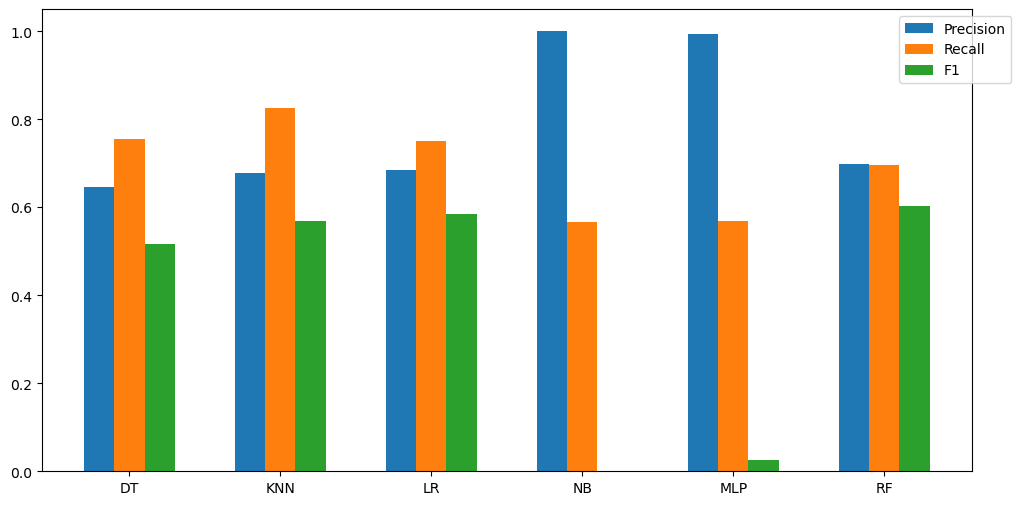

In [121]:
# Generate output
classifiers = ['DT', 'KNN', 'LR', 'NB', 'MLP', 'RF']
precisions = [dt_p, knn_p, lr_p, nb_r, mlp_r, rf_r]
recalls = [dt_r, knn_r, lr_r, nb_p, mlp_p, rf_p]
f1s = [dt_f1, knn_f1, lr_f1, nb_f1, mlp_f1, rf_f1]
x_axis= np.arange(len(classifiers))

plt.figure()
plt.bar(x_axis-0.2, precisions, width=0.2, label="Precision")
plt.bar(x_axis, recalls, width=0.2, label="Recall")
plt.bar(x_axis+0.2, f1s, width=0.2, label="F1")

plt.xticks(x_axis, classifiers)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()


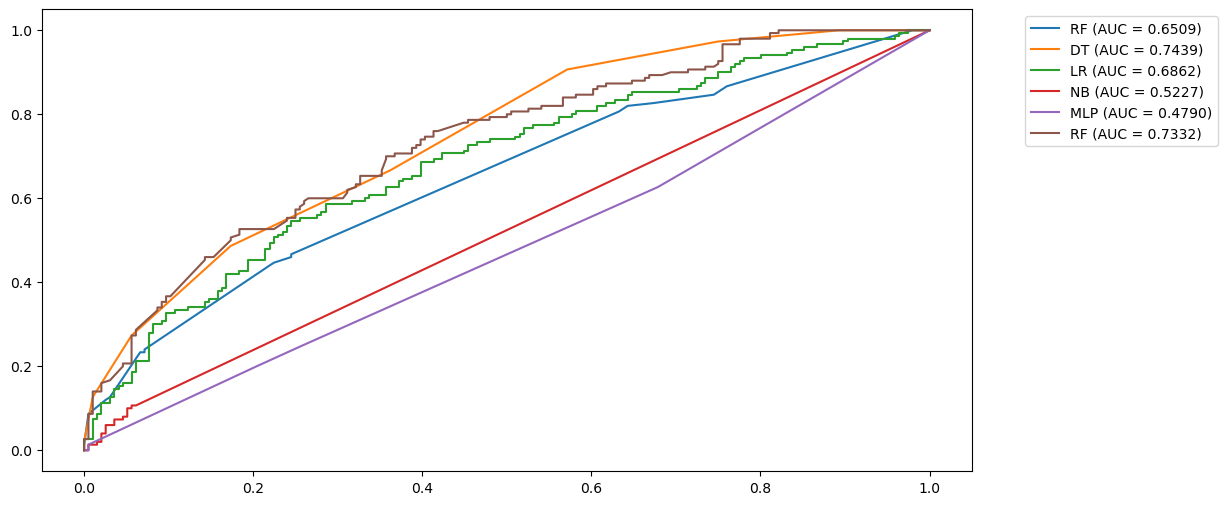

In [122]:
# Make AUC plot
plt.figure()

plt.plot(dt_fpr, dt_tpr, label=dt_legend)
plt.plot(knn_fpr, knn_tpr, label=knn_legend)
plt.plot(lr_fpr, lr_tpr, label=lr_legend)
plt.plot(nb_fpr, nb_tpr, label=nb_legend)
# plt.plot(sv_fpr, sv_tpr, label=sv_legend)
plt.plot(mlp_fpr, mlp_tpr, label=mlp_legend)
plt.plot(rf_fpr, rf_tpr, label=rf_legend)

plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()